**GBA 6430 - Big Data Technology in Business**

**Milestone 2: Data Preprocessing** 

**Group:** Ramon Gomez, Michael Webb, Jonathan Diaz

**Project Objective:** 
- Our project aims to develop a price forecasting model for apartment rentals across the United States. 
- This model will help property managers set appropriate rental prices based on various factors and provide insights for cost-effective property upgrades.

**Method of Analysis:**

Our project will use three main analytical approaches:
- **Regression**: To predict rental prices based on various attributes
- **Clustering**: To group similar properties or regions
- **Classification**: To categorize properties based on specific features

**Dataset Description:**

The dataset contains information on 10,000 apartment listings with 22 columns, including details about the properties, their locations, and rental prices.

**Dependent Variable:**
- **Price**: The rental price of the apartment (what we're trying to predict)

**Independent Variables:**
- **Geographic location**: latitude, longitude, state, cityname
- **Property dimensions**: bedrooms, bathrooms, square_feet
- **Amenities**: features like air conditioning, parking, in-unit laundry
- **Other features**: pets_allowed, has_photo

**Key Column Descriptions:**
- **id**: Unique identifier for each listing
- **category**: Type of rental (e.g., apartment)
- **title**: Brief description of the property
- **body**: Detailed description of the property
- **amenities**: List of available features
- **bathrooms**: Number of bathrooms
- **bedrooms**: Number of bedrooms
- **price**: Rental price
- **square_feet**: Size of the apartment
- **address**: Property location
- **cityname**: City where the property is located
- **state**: State where the property is located
- **latitude and longitude**: Geographic coordinates
- **source**: Where the listing was obtained from
- **time**: Timestamp of the listing

This dataset provides a view of apartment rentals, allowing for analysis of how various factors influence rental prices across different regions in the United States.

In [0]:
#pip install geopy

**Start of Analysis**

**Purpose:**
- This cell is importing necessary libraries and setting up a Spark environment. 
- It's then loading apartment rental data from a CSV file into a DataFrame. 

In [0]:
import requests
from pyspark.sql import SparkSession
import pyspark.pandas as ps
import matplotlib.pyplot as plt
import pprint
from pyspark.sql.functions import from_unixtime, col, mean, stddev, abs as pyspark_abs
import pandas as pd
from pyspark.sql.functions import col, count, split, size, length, when, isnan, regexp_extract, expr
ps.set_option('plotting.backend', 'matplotlib')
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField, StringType
import re

# Initialize Spark session
spark = SparkSession.builder.appName("ReadCSVFile").getOrCreate()

# Define the presigned URL
local_file_path = 'dbfs:/FileStore/files/apartments_for_rent_classified_100K.csv'

# Load the local CSV file into a pandas-on-Spark DataFrame
df = ps.read_csv(local_file_path, sep=";", index_col="id")

# Show the first few rows of the DataFrame
print(df.head())


                          category                                                             title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

**Output:** 
- The output is a table showing the beginning of the dataset. 

# Check Columns 

* Find duplicates
* Missing Values
* Clean formatting, convert categorical to numerical, etc...


In [0]:
# View All Column Names
print(df.to_pandas().dtypes)


category          object
title             object
body              object
amenities         object
bathrooms         object
bedrooms          object
currency          object
fee               object
has_photo         object
pets_allowed      object
price             object
price_display     object
price_type        object
square_feet      float64
address           object
cityname          object
state             object
latitude          object
longitude         object
source            object
time             float64
dtype: object


**Output:**
- This result shows us the structure of the apartment rental dataset. - Each line represents a column in the dataset. 
- The left side shows the column name, like "category" or "price". 
- The right side tells us what kind of data is in that column. 
- Most columns are "object" type, which usually means they contain text. 
- A few columns like "price", "square_feet", and "time" are "int32" type, which means they contain whole numbers. 
- We ran this to help us understand what kind of data we're working with and how we might analyze it later. 

In [0]:
# View All Column Names
df.to_pandas().head()


category  ...          time
id                                  ...              
5668640009  housing/rent/apartment  ...  1.577360e+09
5668639818  housing/rent/apartment  ...  1.577360e+09
5668639686  housing/rent/apartment  ...  1.577360e+09
5668639659  housing/rent/apartment  ...  1.577360e+09
5668639374  housing/rent/apartment  ...  1.577360e+09

[5 rows x 21 columns]

**Purpose:**
- The purpose of this cell is to change the data types of certain columns to make them easier to work with and to add new columns for better analysis. 
- We are converting 'bathrooms' and 'bedrooms' to numbers, change 'latitude' and 'longitude' to decimal numbers, and convert 'time' to a date format. 
- We also create new 'Year' and 'Month' columns from the 'time' column.

In [0]:
# Change Types to match numerical values. 

df['bathrooms'] = df['bathrooms'].astype('float32')
df['bedrooms'] = df['bedrooms'].astype('int32')
df['latitude'] = df['latitude'].astype('float64')
df['longitude'] = df['longitude'].astype('float64')
df['time'] = ps.to_datetime(df['time'], unit='s')

# Create new columns for Year and Month: useful for seasonality analysis 
df['Year'] = df['time'].dt.year
df['Month'] = df['time'].dt.month

df['week_of_month'] = df['time'].dt.day.apply(lambda x: (x - 1) // 7 + 1)

# View All Column Names
df.to_pandas().head()

category  ... week_of_month
id                                  ...              
5668640009  housing/rent/apartment  ...           4.0
5668639818  housing/rent/apartment  ...           4.0
5668639686  housing/rent/apartment  ...           4.0
5668639659  housing/rent/apartment  ...           4.0
5668639374  housing/rent/apartment  ...           4.0

[5 rows x 24 columns]

**Output:**
- The output shows the first few rows of our updated dataset, including the newly formatted columns and the new 'Year' and 'Month' columns. 
- This will help in our analysis of the data to be more accurate.

**Purpose:**
- This cell is checking for duplicate entries in our updated apartment rental dataset. It counts how many rows are exact copies of other rows.

In [0]:
# Count the number of duplicate rows
num_duplicates = df.duplicated().sum()

# Print the number of duplicate rows
print(f"Number of duplicate rows before removal: {num_duplicates}")


Number of duplicate rows before removal: 84


**Output:**
- Analysis shows zero duplicated rows. 

**Purpose:**
- This cell is meant to drop any duplicated rows within our updated dataset. 
- Although we have zero duplicates, we still wanted to run the code for our analysis

In [0]:
# Drop duplicate rows
df = df.drop_duplicates()

# Count the number of duplicate rows
num_duplicates = df.duplicated().sum()

# Print the number of duplicate rows
print(f"Number of duplicate rows after removal: {num_duplicates}")


Number of duplicate rows after removal: 0


**Output:**
- The output shows that we have zero duplicated rows.

### Check for Missing Values

**Purpose:**
- This cell is going through all the text columns in our updated dataset. 
- For each column, it's looking for any entries that say 'null' and replacing them with actual null values (empty or no data).

In [0]:
# we need to make sure strings that are "null" actually appear as null/None/NaN etc in the dataframe

# List of columns to exclude from the loop
exclude_columns = []

# Loop through all object type columns except those in the exclude list
for col in df.select_dtypes(include='object').columns:
    if col not in exclude_columns:
        # Replace 'null' string with actual null values
        df[col] = df[col].where(df[col] != 'null', None)




In [0]:
# Check for missing values in all columns
missing_values = df.isnull().sum()

# Show the missing values
print(missing_values)


category             0
title                0
body                 0
amenities        16087
bathrooms           70
bedrooms           131
currency             7
fee                  7
has_photo            7
pets_allowed     55616
price                8
price_display        8
price_type           7
square_feet          7
address          91974
cityname           309
state              309
latitude            32
longitude           32
source               7
time                 7
Year                 7
Month                7
week_of_month        7
dtype: int64


**Output:**
- The output shows us the amount of null values in each of the columns. 

**Purpose:** 
- Check for missing values again. 

In [0]:
# Show the missing values
print(missing_values)


category             0
title                0
body                 0
amenities        16087
bathrooms           70
bedrooms           131
currency             7
fee                  7
has_photo            7
pets_allowed     55616
price                8
price_display        8
price_type           7
square_feet          7
address          91974
cityname           309
state              309
latitude            32
longitude           32
source               7
time                 7
Year                 7
Month                7
week_of_month        7
dtype: int64


__Address Cleanup__

Address can be found for the null address column in the body column. We impute the null addresses with the body text using a regex pattern.

/*We REMOVED thie section from our cleanup because there were too many errors with the regular expression*/

In [0]:
# import re
# # Define the extraction pattern for the full address
# address_pattern = r'(?:located at|includes :)\s+(.*?)(?=\s*Monthly)'

# # Function to extract the full address from the body
# def extract_full_address(body):
#     match = re.search(address_pattern, body)
#     if match:
#         return match.group(1)
#     return None

# # Apply the extraction function to the body column and create a new column for the full address
# df['full_address'] = df['body'].apply(extract_full_address)

# # Define functions to extract parts of the address
# def get_address_part(full_address, part_index):
#     if full_address:
#         parts = full_address.split(', ')
#         if len(parts) > part_index:
#             return parts[part_index].strip()
#     return None

# # Apply functions to extract address, city, and state parts
# df['address_part'] = df['full_address'].apply(lambda x: get_address_part(x, 0))
# df['city_part'] = df['full_address'].apply(lambda x: get_address_part(x, 1))
# df['state_part'] = df['full_address'].apply(lambda x: get_address_part(x, 3))


In [0]:
# # Filter the DataFrame to show only rows where cleaned_address is not null
# non_null_cleaned_address = df[df['address_part'].notnull()]

# # Print the filtered DataFrame
# non_null_cleaned_address.head()

In [0]:
# # Fill null values in the 'address', 'city', and 'state' columns with values from 'address_part', 'city_part', 'state_part'
# # Manually fill null values using 'where'
# df['address'] = df['address'].where(df['address'].notna(), df['address_part'])
# df['cityname'] = df['cityname'].where(df['cityname'].notna(), df['city_part'])
# df['state'] = df['state'].where(df['state'].notna(), df['state_part'])

# # Display the updated DataFrame to verify the changes
# print(df[['address', 'cityname', 'state']])

In [0]:
# Filter the DataFrame for a row where the id is 5655792181
filtered_df = df.loc[5655792181]
filtered_df['body']
print(filtered_df['body'])
# filtered_df = df[df['address'].str.contains("\$", na=False)]
# print(filtered_df.count)


Square footage: 1100 square feet, unit number: 01913. You can enjoy the convenience of living in a residential community. The spacious and stylish apartments for rent feature today s modern amenities along with extraordinary service. Centre is near the city s top shopping, entertainment, and fine dining options. Choose from a one or two bedrooms apartment that features plenty of space for you to create your dream home. Typi. Price range: $1,774 - $2,389 More units available: 2 Bd / 2 Beds 1,005 sq-ft for $1,709/mo one Bd / 1 Beds 735 square ft for $1,559/mo two Bd / 2 Beds 1,100 square ft for $1,714/mo two Bd / 2 Beds 1,005 square feet for $1,704/mo two Bd / 2 Beds 1,005 sq-ft for $1,694/mo two Bd / 2 Beds 1,005 square ft for $1,679/mo two Bd / 2 Beds 1,005 sq-ft for $1,719/mo two Bd / 2 Beds 1,005 sq. feet for $1,689/mo two Bd / 2 Beds 1,100 square ft for $1,754/mo two Bd / 2 Beds 1,005 sq-ft for $1,764/mo


In [0]:
# View All Column Names
df.to_pandas().head().T

id                                                    5509059597  ...                                         5509069340
category                                  housing/rent/apartment  ...                             housing/rent/apartment
title            $1,000 / One BR - Great Deal. MUST SEE. Pet OK!  ...  $1,040/mo - convenient location. Washer/Dryer ...
body           Square footage: 773 square feet, unit number: ...  ...  When you come home after a long day, youre loo...
amenities                                                   None  ...          Clubhouse,Gym,Parking,Tennis,Washer Dryer
bathrooms                                                    1.0  ...                                                NaN
bedrooms                                                     1.0  ...                                                1.0
currency                                                     USD  ...                                                USD
fee                                                           No  ...                                                 No
has_photo                                                    Yes  ...                                                Yes
pets_allowed                                           Cats,Dogs  ...                                               None
price                                                       1000  ...                                               1040
price_display                                             $1,000  ...                                             $1,040
price_type                                               Monthly  ...                                            Monthly
square_feet                                                773.0  ...                                              761.0
address                                                     None  ...                                               None
cityname                                              Cincinnati  ...                                          Arlington
state                                                         OH  ...                                                 TX
latitude                                                   39.05  ...                                            32.7767
longitude                                               -84.3439  ...                                           -97.0816
source                                              RentDigs.com  ...                                       RentDigs.com
time                                         2019-09-18 01:43:36  ...                                2019-09-18 01:53:57
Year                                                      2019.0  ...                                             2019.0
Month                                                        9.0  ...                                                9.0
week_of_month                                                3.0  ...                                                3.0

[24 rows x 5 columns]

__Future Impute City and State data using Lat Long data__

Currently this set of commands is failing taking too long to finish. For now we will remove the rows in our analysis but hopefully in the future apply this imputation to retain more data. 

We can also apply this in the reverse if the lat and long are null but the address, city, state data is not. we can reverse search the lat and long and inpute that back. 

In [0]:
# import pandas as pd
# from geopy.geocoders import Nominatim
# from geopy.exc import GeocoderTimedOut, GeocoderUnavailable
# import time

# def get_city_state(lat, lon):
#     if pd.isna(lat) or pd.isna(lon):
#         return pd.NA, pd.NA  # Return NA for null coordinates
    
#     geolocator = Nominatim(user_agent="my_agent")
#     try:
#         location = geolocator.reverse(f"{lat}, {lon}")
#         address = location.raw['address']
#         city = address.get('city', pd.NA)
#         state = address.get('state', pd.NA)
#         return city, state
#     except (GeocoderTimedOut, GeocoderUnavailable):
#         time.sleep(1)
#         return get_city_state(lat, lon)  # Retry
#     except:
#         return pd.NA, pd.NA  # Return NA if geocoding fails

# # Apply the function to your DataFrame
# df[['City', 'State']] = df.apply(lambda row: get_city_state(row['latitude'], row['longitude']), axis=1, result_type='expand')

**Purpose:**
- The cell is searching through the entire dataset to find any rows that have missing information (null values) in any of the columns. 
- We then create a new dataset containing only these rows with missing data.

In [0]:
import pyspark.pandas as ps

# Enable operations on different DataFrames
ps.options.compute.ops_on_diff_frames = True

# Check for null values in each column and create a mask
null_mask = df.isnull().sum(axis=1) > 0

# Filter rows with any null values
rows_with_nulls = df[null_mask]

# Convert to pandas DataFrame for nicer display
rows_with_nulls_pandas = rows_with_nulls.to_pandas()

# Get the count of rows with null values
count_rows_with_nulls = rows_with_nulls.shape[0]

# Show the rows with null values
print(f"Number of rows with null values: {count_rows_with_nulls}")

Number of rows with null values: 95907


**Output:**
- The output is showing 0 rows with missing values.

__Impute Nulls for different columns__

**Purpose:** 
- In this cell, we want to impute nulls for different columns. 

In [0]:
# This doesn't explicit say No pets allowed but does declare if cats, dogs, or both are allowed. If this is null then we will put "Unknown" as the string value. 
df['pets_allowed'] = df['pets_allowed'].fillna('Unknown')

# Amenities may also be null but that doesn't mean it doesn't have them. It just is not declared. We will fill Amenities as Unknown since we don't actually know
df['amenities'] = df['amenities'].fillna('Unknown')

# Bathrooms have null values but if these are shared living spaces with shared restrooms then these listings have an unknown  amount of bathrooms. For our analysis since this is a numerical column we will imput the value of 0 because there are 0 listed bathrooms. This also applies to the bedroom nulls where a studio apartment may have no bedrooms and a single living space. 
df['bathrooms'] = df['bathrooms'].fillna(0)
df['bedrooms'] = df['bedrooms'].fillna(0)

# The address columns has many nulls and that level of location detail will not be useful for us so we will remove this column. We have latitude and longitude for most of our data so if we want to find distance and cluster location data we will rely on lat and long instead. 
df = df.drop(columns=['address'])

#remove price_display Column. This is just a string version of the price.
df = df.drop(columns=['price_display'])

# For nulls in cityname, state,lat and long we will need to remove these rows because our analysis is very region specific and we must know the state and city level locations to aggregate regional data. 
df = df.dropna(subset=['cityname', 'state', 'latitude', 'longitude'])

**Purpose:** 
- In this cell, we rerun missing values in all columns. 

In [0]:
# Check for missing values in all columns
missing_values = df.isnull().sum()

# Show the missing values
print(missing_values)

category         0
title            0
body             0
amenities        0
bathrooms        0
bedrooms         0
currency         0
fee              0
has_photo        0
pets_allowed     0
price            1
price_type       0
square_feet      0
cityname         0
state            0
latitude         0
longitude        0
source           0
time             0
Year             0
Month            0
week_of_month    0
dtype: int64


**Output:** 
- Our output shows no missing values now. 

### Check Unique Values In Categorical Columns

**Purpose:**
- This cell is meant to check for unique values within categorical columns. 
- If a column has more than 60 unique values, it prints a message indicating the column name and the number of unique values.
- If a column has 60 or fewer unique values, it prints out all the unique values in that column, along with the count of these unique values.

In [0]:
# Loop through all object type columns except 'title' and 'body'
for col in df.select_dtypes(include='object').columns:
    if col not in ['title', 'body','price_display','address','']:
        unique_values = df[col].unique()
        unique_count = len(unique_values)
        if unique_count > 60:
            print(f"Column '{col}' has {unique_count} unique values.\n")
        else:
            print(f"Unique values in '{col}' column:")
            print(unique_values)
            print(f"\nNumber of unique values in '{col}': {unique_count}\n")

Unique values in 'category' column:
0    housing/rent/commercial/retail
1            housing/rent/apartment
2                 housing/rent/home
3                housing/rent/condo
4                      housing/rent
5           housing/rent/short_term
6                housing/rent/other
Name: category, dtype: object

Number of unique values in 'category': 7

Column 'amenities' has 9831 unique values.

Unique values in 'currency' column:
0    USD
Name: currency, dtype: object

Number of unique values in 'currency': 1

Unique values in 'fee' column:
0     No
1    Yes
Name: fee, dtype: object

Number of unique values in 'fee': 2

Unique values in 'has_photo' column:
0    Thumbnail
1           No
2          Yes
Name: has_photo, dtype: object

Number of unique values in 'has_photo': 3

Unique values in 'pets_allowed' column:
0              None
1         Cats,Dogs
2           Unknown
3              Dogs
4              Cats
5    Cats,Dogs,None
Name: pets_allowed, dtype: object

Number of uni

**Output:**
- The cell outputted the distribution of unique values within the categorical columns. 
- For columns with a manageable number of unique values (≤60), it lists them out. 
- For those with a large number of unique values (>60), it indicates the count to avoid overwhelming the output. 
- This helps us in understanding the variability and uniqueness of data within different columns, which is useful for our data cleaning, analysis, and preprocessing steps.

#### Analyzing Amenities Column

**Purpose:**
- This cell is meant to check to see the frequencies of each unique amentity. 
- We noticed that amenities has many duplicated strings and future feature selection possibilities.
- We believe this may give us insight to see if using get dummies might be helpful in creating new columns. 

In [0]:
from collections import Counter
import pyspark.sql.functions as F

# Define a function to split the amenities string into a list of features
def split_amenities(amenities):
    if pd.isna(amenities):
        return []
    return amenities.split(',')

# Apply the function to the amenities column and flatten the resulting list
all_features = df['amenities'].apply(split_amenities).explode()

# Filter out None values
all_features = all_features[all_features.notna()]

# Convert to pandas DataFrame for counting
all_features_pandas = all_features.to_pandas()

# Count occurrences of each feature
feature_counts = Counter(all_features_pandas)

# Convert to a DataFrame for nicer display
feature_counts_df = pd.DataFrame(feature_counts.items(), columns=['Feature', 'Count']).sort_values(by='Count', ascending=False)

# Display the result
print(feature_counts_df)


               Feature  Count
4              Parking  43906
5                 Pool  43620
2                  Gym  37413
17          Patio/Deck  26584
8         Washer Dryer  26097
12             Storage  21697
6            Clubhouse  19149
16          Dishwasher  16628
0              Unknown  15945
15                  AC  15845
1            Fireplace  14968
11        Refrigerator  14924
9   Cable or Satellite  12551
18          Playground  11341
10     Internet Access  11104
14         Wood Floors   8886
13               Gated   8679
7               Tennis   8529
3                   TV   4509
21            Elevator   4340
20          Basketball   4155
19             Hot Tub   3996
24    Garbage Disposal   3875
22                View   2098
23               Alarm    364
25             Doorman    219
26              Luxury    207
27                Golf     27


**Output:**
- The output shows the frequency of each amenity within our dataset. 

**Purpose:**
- In this cell, we created a bar chart to display the count of unique features in the amenities. 

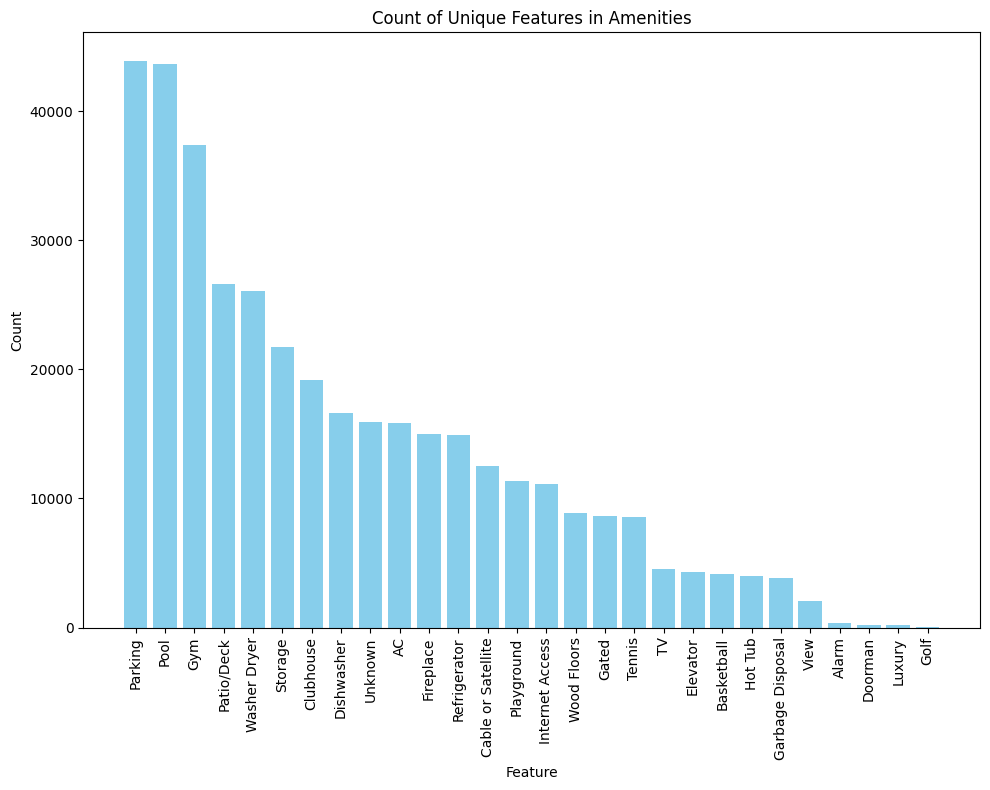

In [0]:
# Plot the bar chart
plt.figure(figsize=(10, 8))
plt.bar(feature_counts_df['Feature'].tolist(), feature_counts_df['Count'].tolist(), color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Count')
plt.title('Count of Unique Features in Amenities')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Output:**
- The ouput displays the frequency of unique values within the amenities column. 
- For example, we can see the most comment amentities within our apartment dataset such as parking, dishwasher, pool, refrigerator etc..

## Generating Descriptive Statistics (Before Outliers)

In [0]:
# List of columns to exclude from the loop
exclude_columns = ['amenities']

# Dictionary to store statistics
num_stats = {}
cat_stats = {}
# Loop through all columns
for col in df.columns:
    if col in exclude_columns:
        continue  # Skip excluded columns
    
    if pd.api.types.is_numeric_dtype(df[col]):
        # Numerical column statistics
        num_stats[col] = {
            'mean': df[col].mean(),
            'median': df[col].median(),
            'std_dev': df[col].std(),
            'min': df[col].min(),
            'max': df[col].max(),
            'count': df[col].count(),
            'missing_values': df[col].isnull().sum()
        }
    elif df[col].dtype == 'object':
        # Categorical column statistics
        unique_values = df[col].value_counts()
        cat_stats[col] = {
            'unique_count': unique_values.count(),
            'mode': df[col].mode()[0],
            'top_categories': unique_values.to_dict(),
            'count': df[col].count(),
            'missing_values': df[col].isnull().sum()
        }

# Convert the statistics dictionary to a pandas DataFrame for nicer display
numeric_stats_df = pd.DataFrame.from_dict(num_stats, orient='index')
categorical_stats_df = pd.DataFrame.from_dict(cat_stats, orient='index')


/databricks/spark/python/pyspark/pandas/base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(
/databricks/spark/python/pyspark/pandas/base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(
/databricks/spark/python/pyspark/pandas/base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(
/databricks/spark/python/pyspark/pandas/base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(
/databricks/spark/python/pyspark/pandas/base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(
/databricks/spark/python/pyspark/pandas/base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(
/databricks/spark/python/pyspark/pandas/base.py:1437: FutureWarning: The resulting

**Output:** In the output, we see rows with NaN meaning there is no corelation with those columns. 

In [0]:
# Display the statistics DataFrame
print(numeric_stats_df)

                      mean     median  ...  count  missing_values
bathrooms         1.444602     1.0000  ...  99607               0
bedrooms          1.725903     2.0000  ...  99607               0
square_feet     955.988525   900.0000  ...  99607               0
latitude         36.943328    37.2139  ...  99607               0
longitude       -91.541372   -84.5451  ...  99607               0
Year           2018.838606  2019.0000  ...  99607               0
Month             7.463241     9.0000  ...  99607               0
week_of_month     3.161967     3.0000  ...  99607               0

[8 rows x 7 columns]


In [0]:
# Display the statistics DataFrame
print(categorical_stats_df)

              unique_count  ... missing_values
category                 7  ...              0
title                58522  ...              0
body                 94669  ...              0
currency                 1  ...              0
fee                      2  ...              0
has_photo                3  ...              0
pets_allowed             6  ...              0
price                 3687  ...              1
price_type               3  ...              0
cityname              2982  ...              0
state                   51  ...              0
source                  25  ...              0

[12 rows x 5 columns]


## Correlation Matrix


**Purpose:** 
- In these cells, we are evaulating the realtionshoip between variables within our dataset.

In [0]:
df.dtypes

category             object
title                object
body                 object
amenities            object
bathrooms           float32
bedrooms              int32
currency             object
fee                  object
has_photo            object
pets_allowed         object
price                object
price_type           object
square_feet           int32
cityname             object
state                object
latitude            float64
longitude           float64
source               object
time             datetime64
Year                  int64
Month                 int64
week_of_month         int64
dtype: object

In [0]:
# Create the correlation matrix
included_numeric_types= ['float64', 'int64', 'float32','int32','int64']
correlation_matrix = df.select_dtypes(include=included_numeric_types).corr()

# Display the correlation matrix
print(correlation_matrix)

               bathrooms  bedrooms  square_feet  latitude  longitude      Year     Month  week_of_month
bathrooms       1.000000  0.678579     0.671816 -0.091136  -0.011867 -0.010039 -0.037088       0.006591
bedrooms        0.678579  1.000000     0.661776  0.012938   0.039958  0.001440  0.000630       0.003845
square_feet     0.671816  0.661776     1.000000 -0.033074   0.063132 -0.005131 -0.004512      -0.003502
latitude       -0.091136  0.012938    -0.033074  1.000000   0.079851  0.134982  0.058051       0.023941
longitude      -0.011867  0.039958     0.063132  0.079851   1.000000 -0.006279  0.034343      -0.068176
Year           -0.010039  0.001440    -0.005131  0.134982  -0.006279  1.000000 -0.508339       0.768297
Month          -0.037088  0.000630    -0.004512  0.058051   0.034343 -0.508339  1.000000      -0.731397
week_of_month   0.006591  0.003845    -0.003502  0.023941  -0.068176  0.768297 -0.731397       1.000000


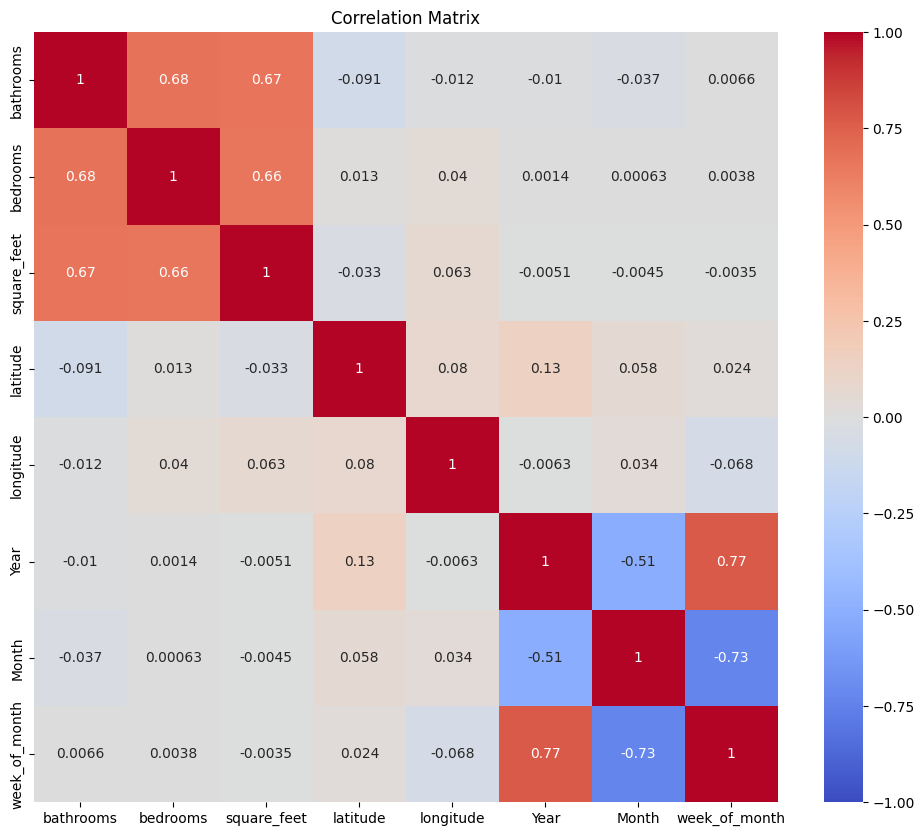

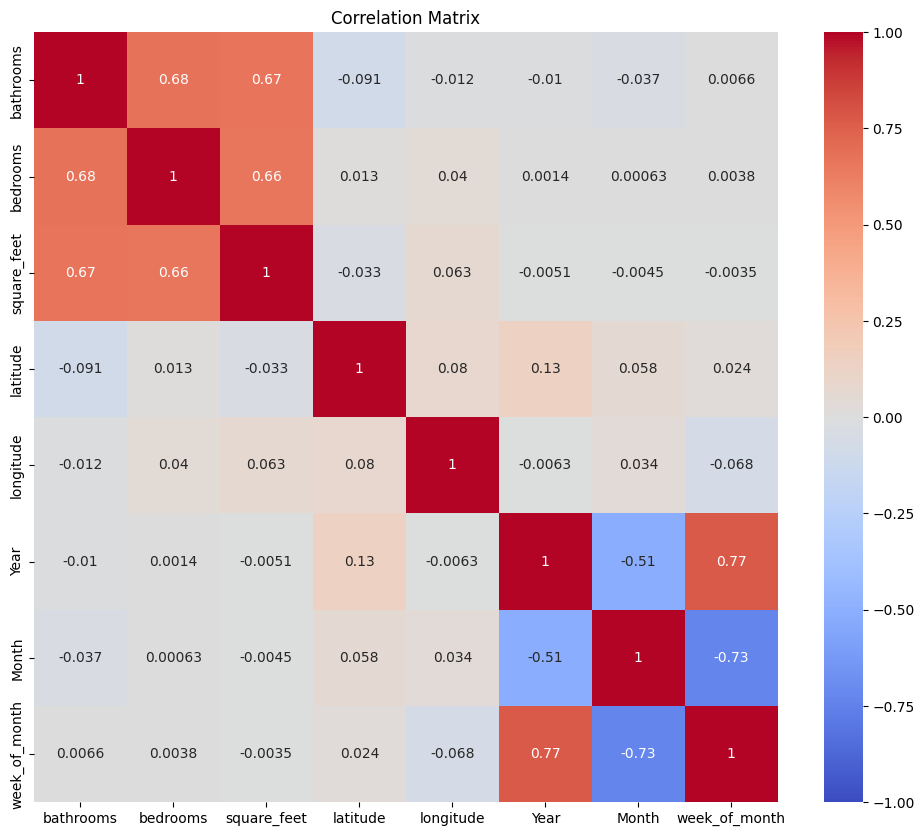

In [0]:
import pyspark.pandas as ps
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric columns
numeric_df = df.select_dtypes(include=included_numeric_types)

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Convert to pandas DataFrame for visualization
pd_correlation_matrix = correlation_matrix.to_pandas()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(pd_correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix')

# If you're in a Databricks notebook, use display() instead of plt.show()
display(plt.gcf())

**Output:** In the output, if the corelation matrix is blank, that means there is no relationship. 
- We can potentially remove these columns. 

In [0]:
print(correlation_matrix)

               bathrooms  bedrooms  square_feet  latitude  longitude      Year     Month  week_of_month
bathrooms       1.000000  0.678579     0.671816 -0.091136  -0.011867 -0.010039 -0.037088       0.006591
bedrooms        0.678579  1.000000     0.661776  0.012938   0.039958  0.001440  0.000630       0.003845
square_feet     0.671816  0.661776     1.000000 -0.033074   0.063132 -0.005131 -0.004512      -0.003502
latitude       -0.091136  0.012938    -0.033074  1.000000   0.079851  0.134982  0.058051       0.023941
longitude      -0.011867  0.039958     0.063132  0.079851   1.000000 -0.006279  0.034343      -0.068176
Year           -0.010039  0.001440    -0.005131  0.134982  -0.006279  1.000000 -0.508339       0.768297
Month          -0.037088  0.000630    -0.004512  0.058051   0.034343 -0.508339  1.000000      -0.731397
week_of_month   0.006591  0.003845    -0.003502  0.023941  -0.068176  0.768297 -0.731397       1.000000


## Generating Visualizations (Before Outliers)

**Purpose:**
- This cell is meant to create histograms for our numeric columns and bar charts for our catergorical columns. 
- This will help us to visually interpret our dataset to determine if we need to remove any outliers. 

/databricks/spark/python/pyspark/pandas/base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(


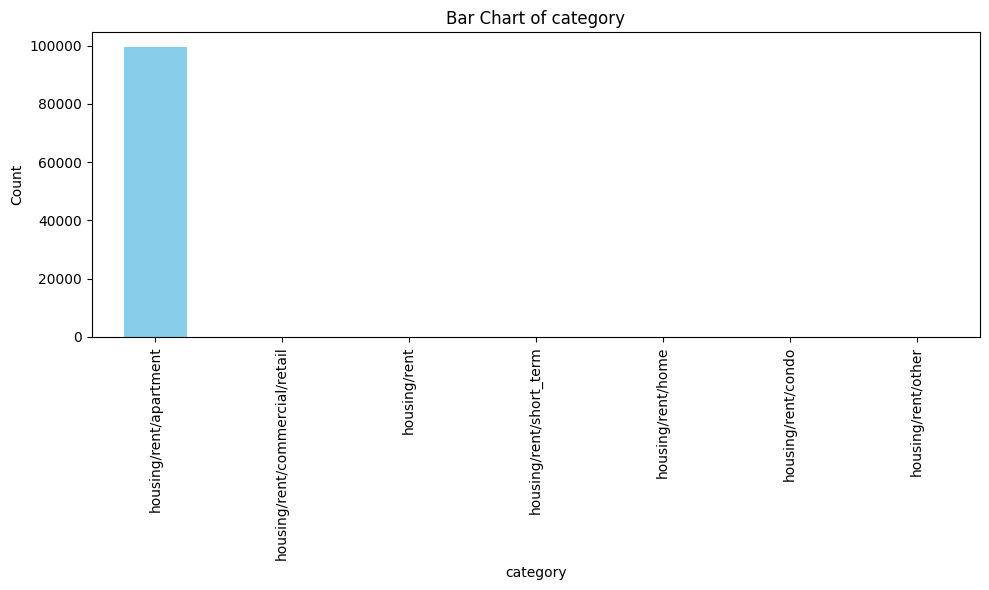

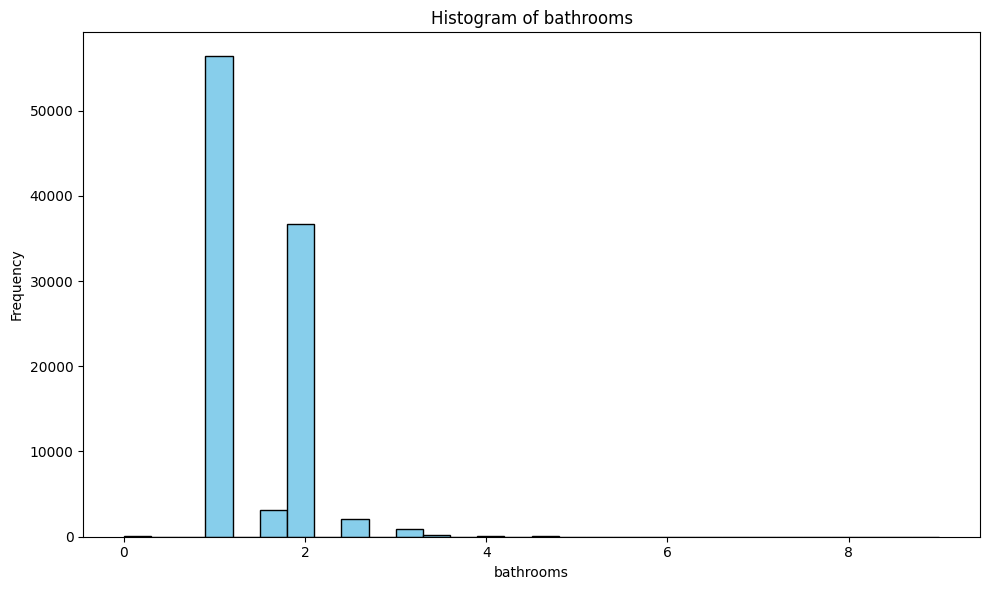

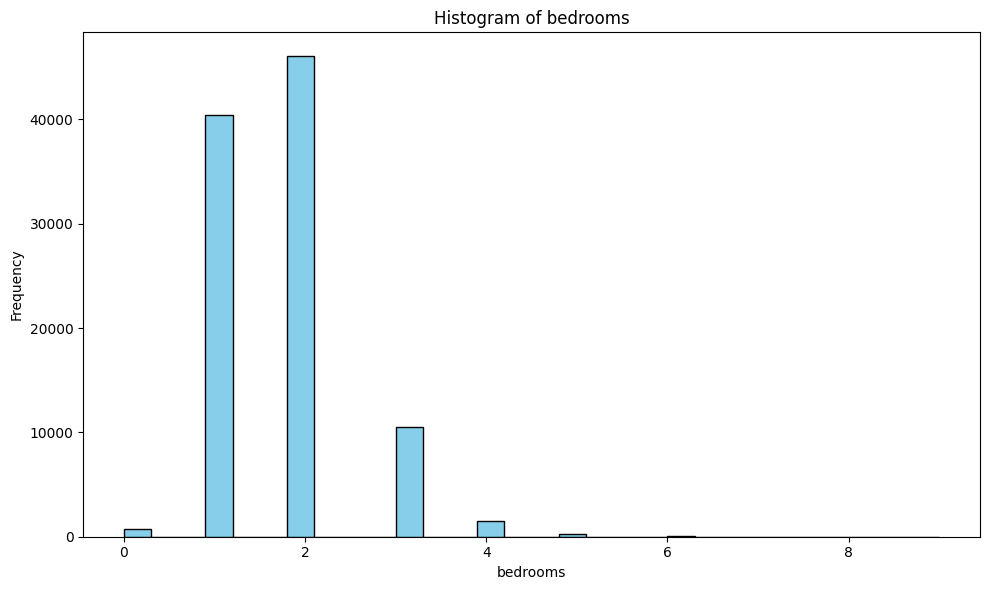

/databricks/spark/python/pyspark/pandas/base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(


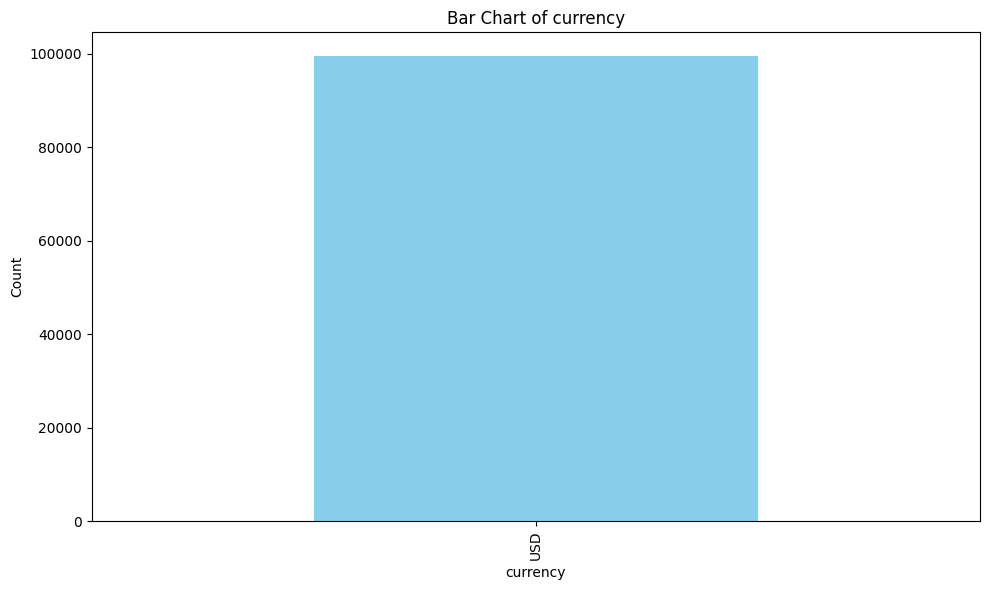

/databricks/spark/python/pyspark/pandas/base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(


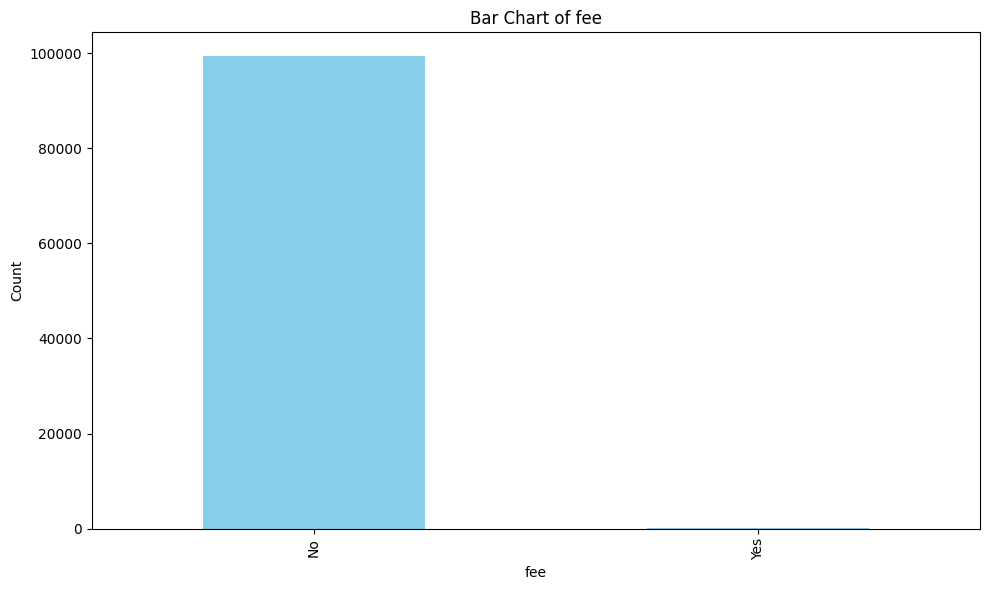

/databricks/spark/python/pyspark/pandas/base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(


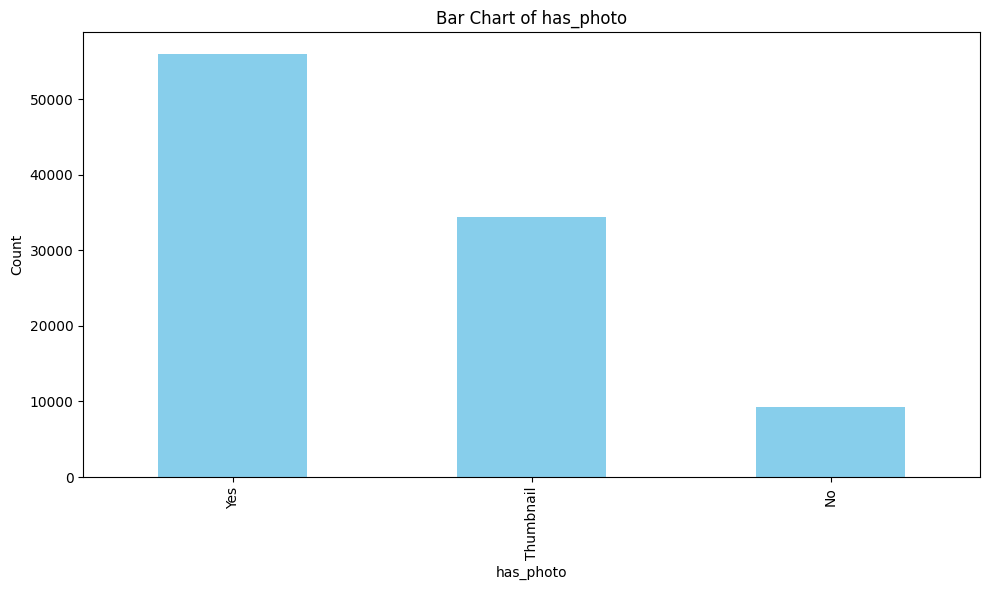

/databricks/spark/python/pyspark/pandas/base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(


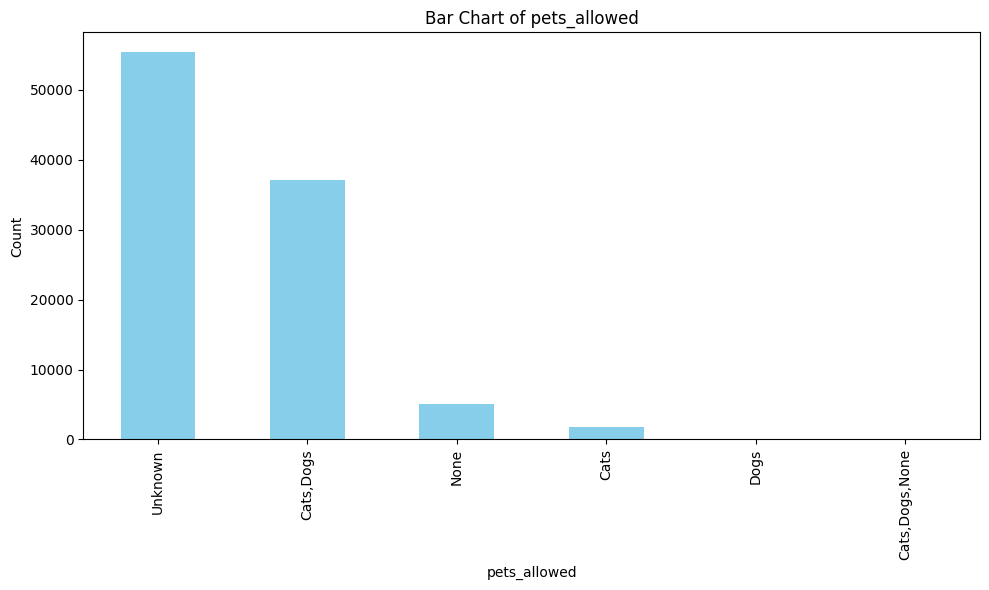

/databricks/spark/python/pyspark/pandas/base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(


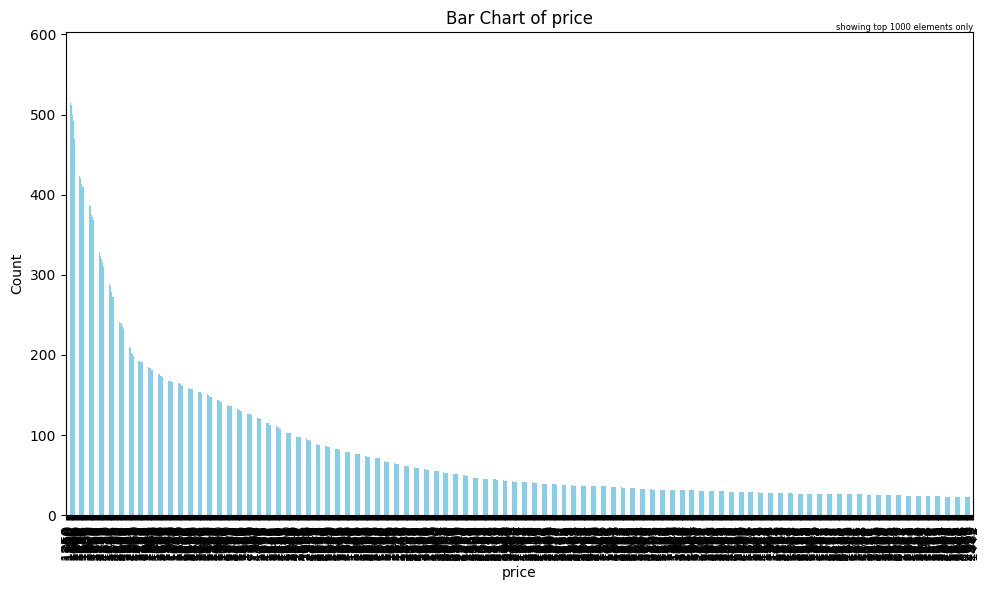

/databricks/spark/python/pyspark/pandas/base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(


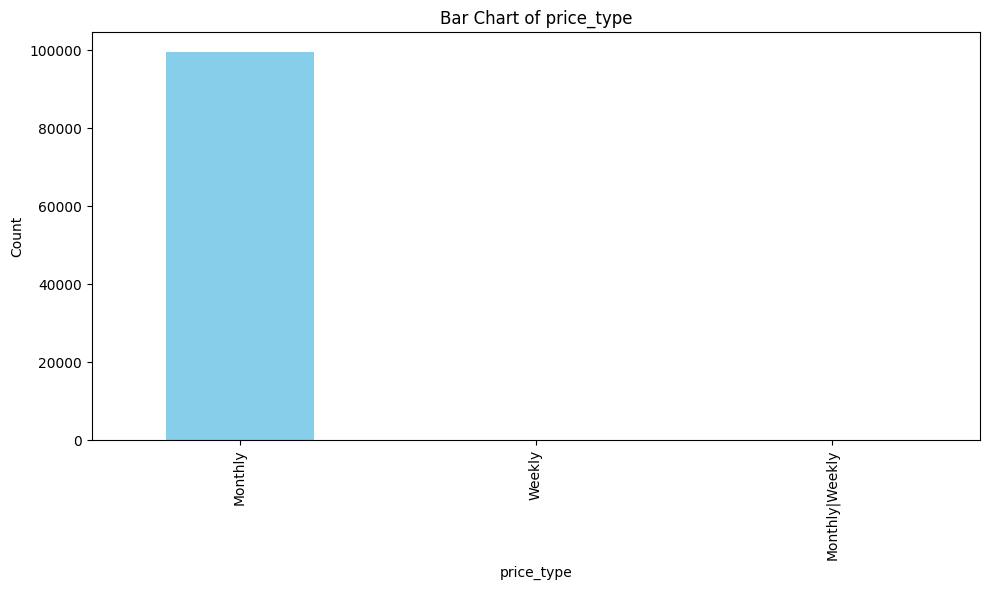

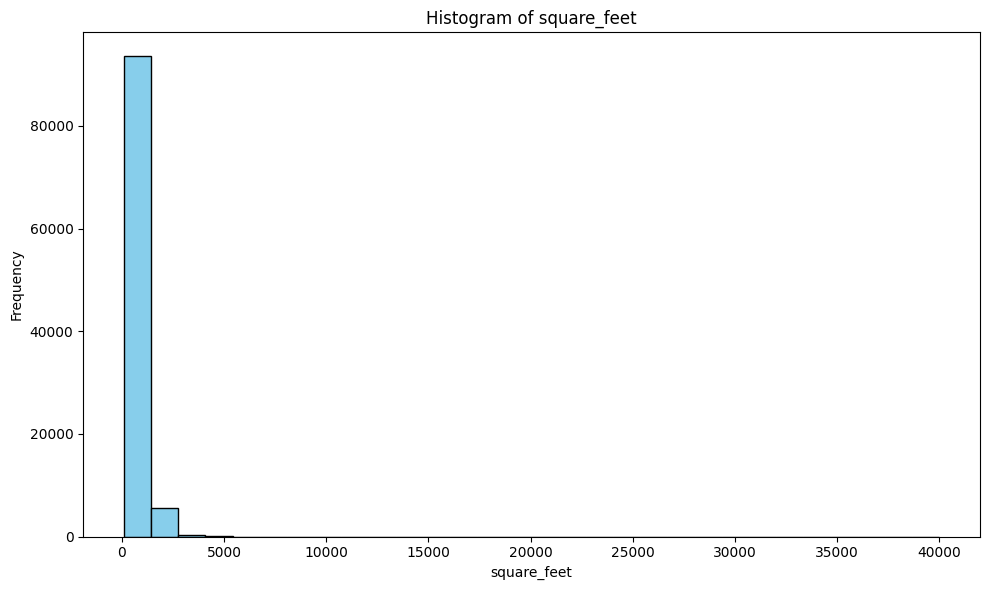

/databricks/spark/python/pyspark/pandas/base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(


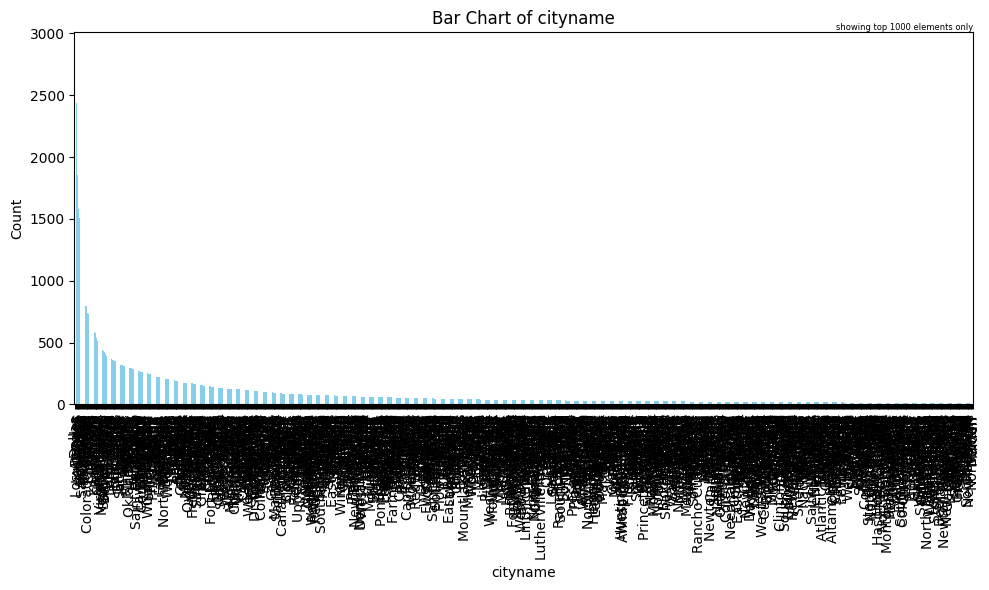

/databricks/spark/python/pyspark/pandas/base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(


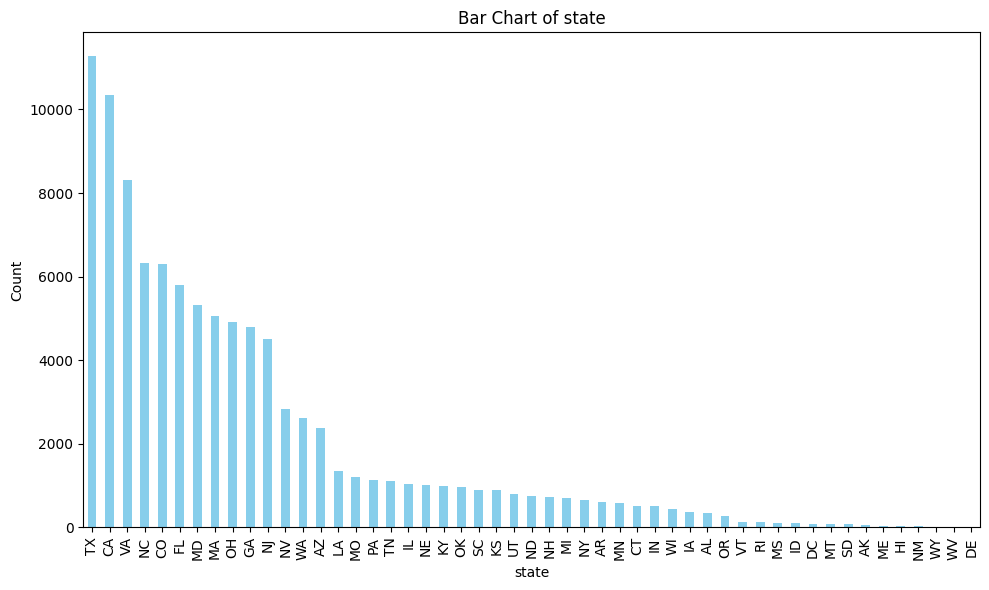

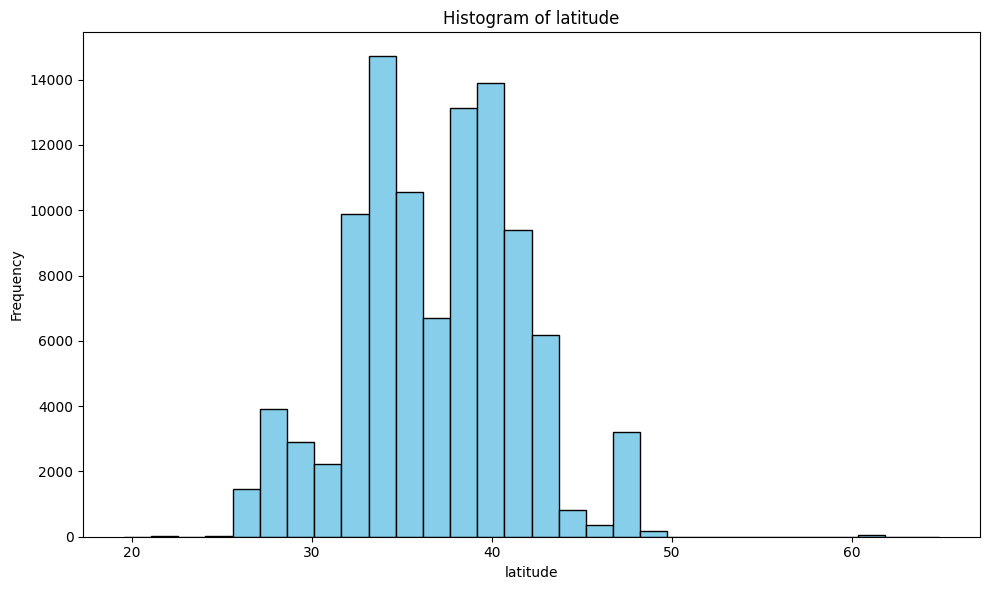

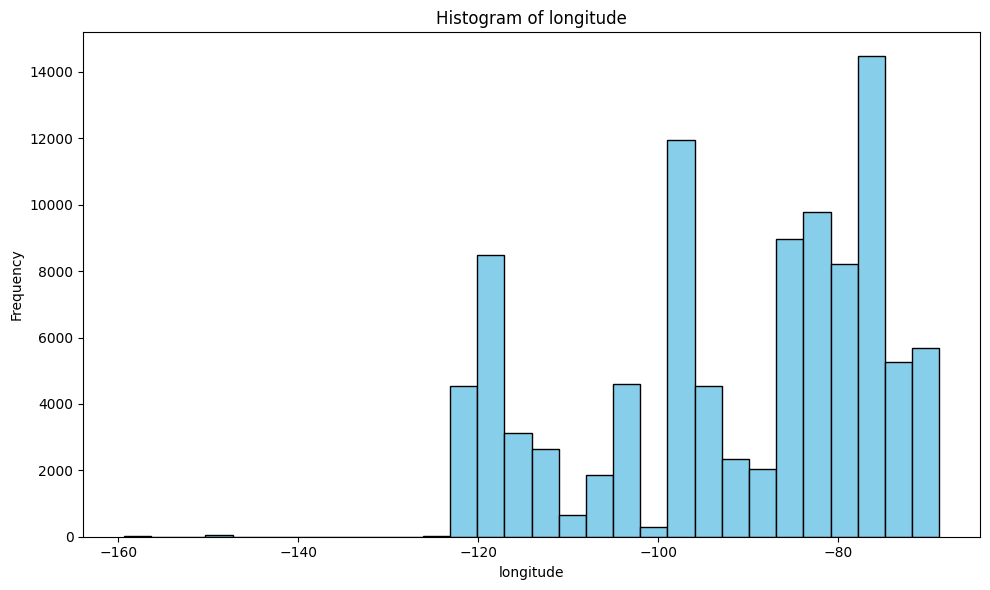

/databricks/spark/python/pyspark/pandas/base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(


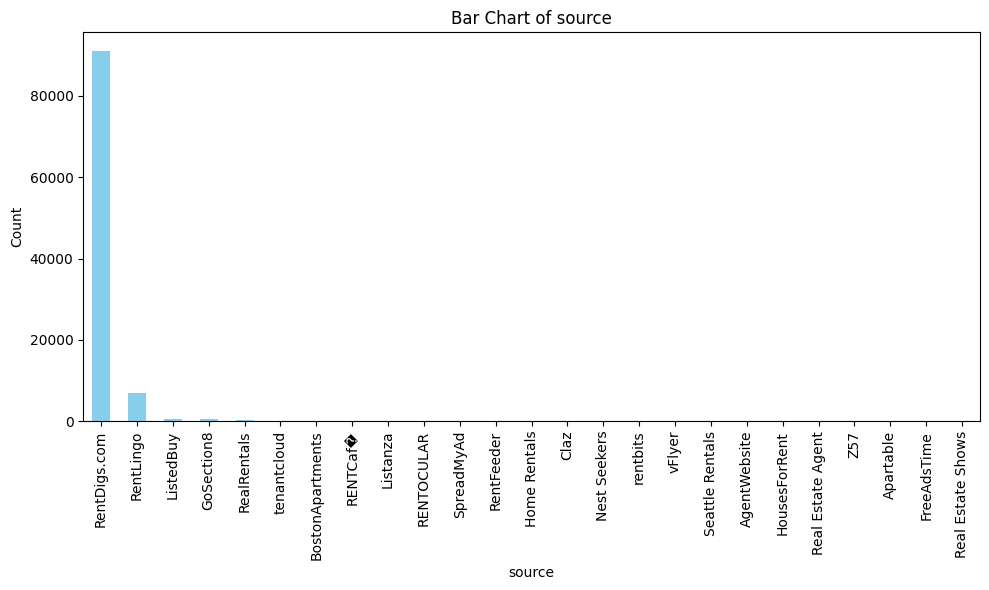

<Figure size 1000x600 with 0 Axes>

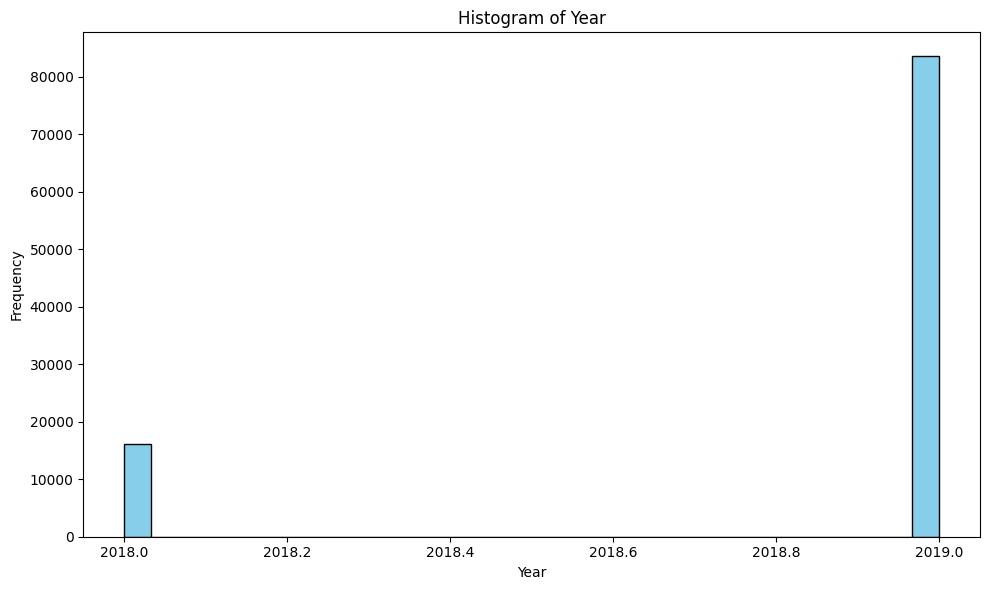

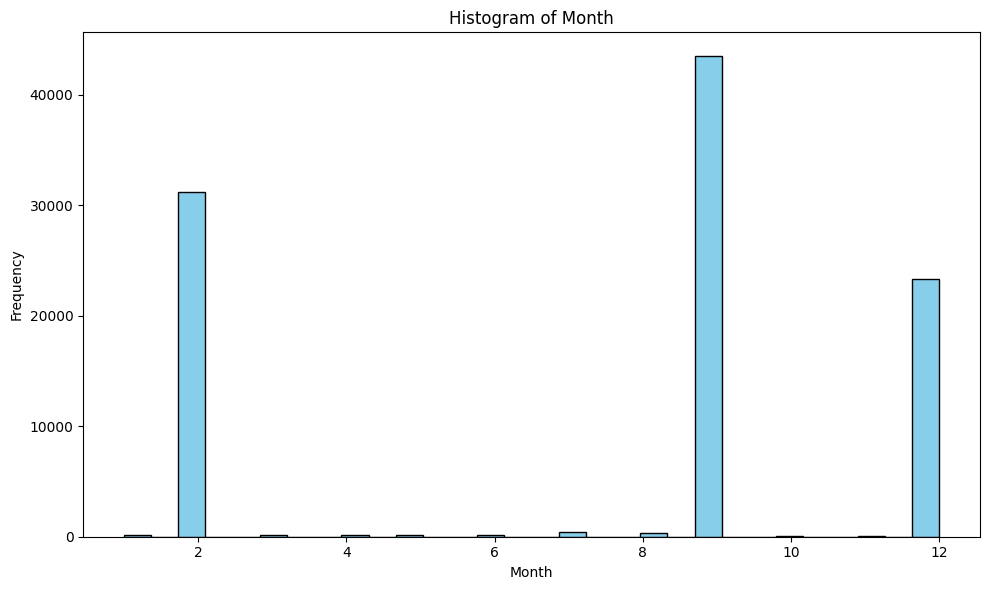

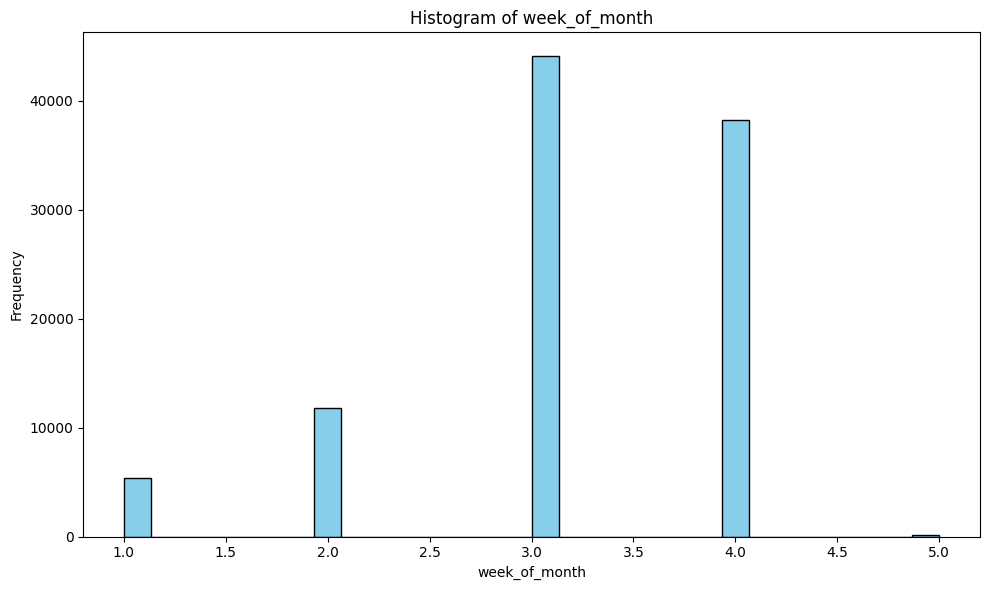

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# List of columns to exclude from the loop
exclude_columns = ['title', 'body','address','price_display','amenities']

# Loop through all columns
for col in df.columns:
    if col in exclude_columns:
        continue  # Skip excluded columns
    
    plt.figure(figsize=(10, 6))
    
    # If the column is categorical, plot a bar chart
    if df[col].dtype == 'object':
        value_counts = df[col].value_counts()
        value_counts.plot(kind='bar', color='skyblue')
        plt.title(f'Bar Chart of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=90)
        plt.tight_layout()

    # If the column is numerical, plot a histogram
    elif pd.api.types.is_numeric_dtype(df[col]):
        df[col].plot(kind='hist', bins=30, color='skyblue', edgecolor='black')
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.tight_layout()

    # Show the plot
    plt.show()


### Visualization Explanation and Analysis
1. **Bar Chart of category:** In this bar chart, we can see that majority of this columnm within our dataset is "housing/rent/apartment."
2. **Bar Chart of amentities:** In this bar chart, we can see that there are thousands of unique amentiies within the the amenities column. This visualization helped us determine that the apartments amenities within our dataset are very unique.
3. **Histogram of bathrooms:** In this histogram, we can see that majority of the apartments come with at least 1 bathroom. We also see that there are a few that have more than one restroom. 
4. **Histogram of bedrooms:** In this histogram, we can see that majority of the apartments have 1-2 bedrooms. There are some that do come with more. 
5. **Bar Chart of currency:** In this bar chart, we see that the only currency in the dataset is 'USD' for us dollars.
6. **Bar Chart of fee:** In this bar chart, we can see that all apartments do not have a fee. 
7. **Bar Chart of has_photo:** In this bar chart, we see most apartments have a thumbnail in the has_photo column. This means that there is a photo there but a smaller image representation of a larger image.
8. **Bar Chart of pets_allowed:** In this bar chart, we see that most apartment allow both cats and dogs. 
9. **Histogram of price:** In this histogram of price, we can see that majority of the data is located on the left side of the graph, and the mean, or average, is greater than the median. 
10. **Bar Chart of price_display:** In this bar chart, we see that the data is skewed to the right. Meaning that most of the data is greater than the median. 
11. **Barchart of price type:** Visualizes the count of different price types within the dataset with monthly being the most common price type. While, weekly and a combination of weekly/monthly showing up significantly less.  
12. **Histogram of square feet:** This histogram explains the distribution of square feet of apartments in the dataset. A majority of the properties are small and range from around 500 sq ft to about 1000 sq ft.
13. **Barchart of address:** This is a barchart of unique address listings. There is one address that appears twice but the listing is for two different apartment types in the same location. 
14. **Barchart of city name:** This chart visualizes the count of listings in different cities within the dataset. Since the chart's x-axis is crowded and ranges from 200 counts down to 1 count  it may be better to choose the cities with the highest counts. This should reduce crowding and help understand the visual better.
15. **Barchart of state:** This chart visualizes the count of listings in different states within the dataset. Texas, California, and Washington hold the highest amount of listings in this dataset
16. **Barchart of source:** This chart visualizes the count of sources within the dataset. RentLingo and RentDigs.com dominate the dataset, providing a majority of the listings. The uneven distribution of the source may have an impact on the data and its quality. 
17. **Histogram of year:** This histogram shows the distribution of when the data was collected. A majority of the data has been collected from 2019. The dataset lacks diversity in terms of the year the listings were recorded. This could indicate that the data was collected or is relevant only for the year 2019.

The absence of data from other years suggests that any temporal analysis or year over year  trend identification is not possible with this dataset.


18. **Histogram of month:** This histogram shows the distribution of what months the listings were posted. The listings are highly concentrated with listings from December and October and few listings from October and November. The uneven distribution may indicate that it is seasonally skewed or that there was a focus on these months.

## Handle Outliers

O
Outliers found in the following columns:


## Generating Descriptive Statistics and Visualizations (After Outliers)

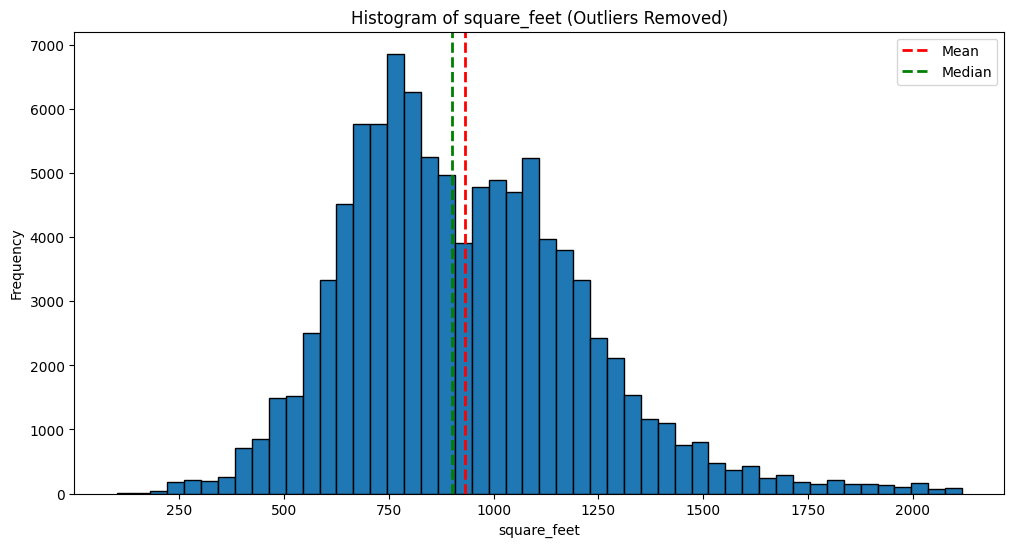

Statistics for square_feet (after removing outliers):
Mean: 931.88
Median: 900.00
Standard Deviation: 284.41
Min: 101.00
Max: 2118.00
Number of data points: 98361
Number of outliers removed: 1246




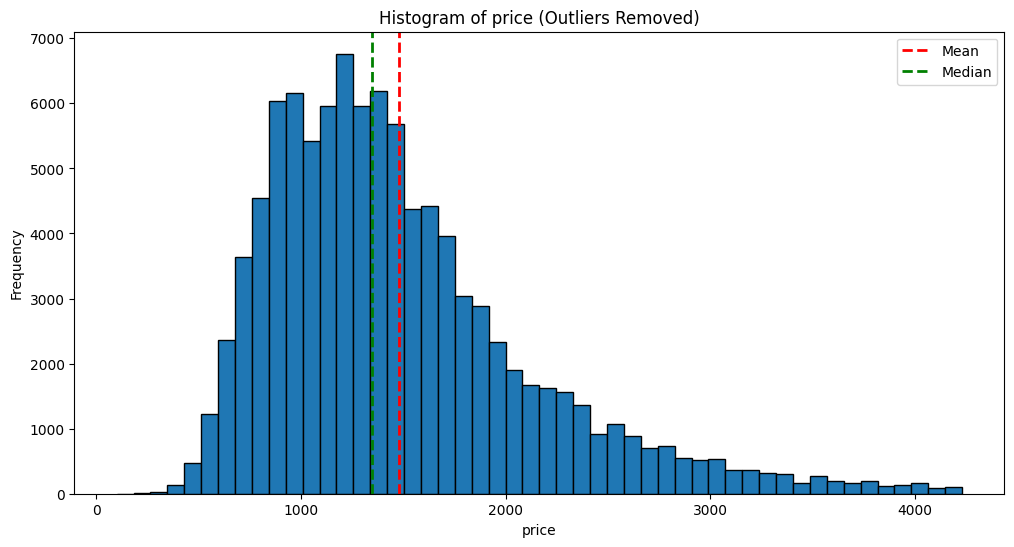

Statistics for price (after removing outliers):
Mean: 1476.64
Median: 1349.00
Standard Deviation: 645.36
Min: 100.00
Max: 4229.00
Number of data points: 98602
Number of outliers removed: 1004




In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pyspark.pandas as ps

def plot_histogram_without_outliers(df, column, z_threshold=3):
    # Convert column to numeric and drop NaN values
    df[column] = df[column].astype(float)
    df = df.dropna(subset=[column])
    
    # Convert the column to a Pandas Series for numeric operations
    pd_series = df[column].to_pandas()
    
    # Calculate z-scores
    mean = pd_series.mean()
    std = pd_series.std()
    z_scores = np.abs((pd_series - mean) / std)
    
    # Filter out outliers
    data_without_outliers = pd_series[z_scores < z_threshold]
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.hist(data_without_outliers, bins=50, edgecolor='black')
    plt.title(f'Histogram of {column} (Outliers Removed)')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    
    # Add some statistics to the plot
    plt.axvline(data_without_outliers.mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')
    plt.axvline(data_without_outliers.median(), color='green', linestyle='dashed', linewidth=2, label='Median')
    
    plt.legend()
    
    # Display the plot
    plt.show()
    
    # Print some statistics
    print(f"Statistics for {column} (after removing outliers):")
    print(f"Mean: {data_without_outliers.mean():.2f}")
    print(f"Median: {data_without_outliers.median():.2f}")
    print(f"Standard Deviation: {data_without_outliers.std():.2f}")
    print(f"Min: {data_without_outliers.min():.2f}")
    print(f"Max: {data_without_outliers.max():.2f}")
    print(f"Number of data points: {len(data_without_outliers)}")
    print(f"Number of outliers removed: {len(pd_series) - len(data_without_outliers)}")
    print("\n")

# Plot histograms for 'square_feet' and 'price'
columns_to_plot = ['square_feet', 'price']

for column in columns_to_plot:
    plot_histogram_without_outliers(df, column)


#### Results: Descriptive stats and Visualizations after outliers
- We created two histograms and generated descriptive statistics based off of the columns where we removed outliers, price and square_feet. 
1. **Histogram of square feet (Outliers Removed):** Within the histogram, we created a red dashed line representing our mean and green dashed line representing our median. 
- The statistics provided give us a clear picture of apartment sizes in the dataset after removing outliers. 
- On average, apartments are about 912 square feet, with half being smaller than 800 square feet and half larger. 
- The sizes typically vary by about 426 square feet above or below this average. 
- The smallest apartment in the dataset is 101 square feet, while the largest is 2,916 square feet. 
- This information comes from analyzing 9,818 apartments, after removing 105 that had extremely large or small sizes.
- These numbers help us understand the typical range of apartment sizes in our cleaned dataset and give us a more accurate view of the rental market by excluding unusual cases that could distort the overall picture.
2. **Histogram of price (Outliers Removed):**
- Right skewed distribution, most properties are lower priced with fewer properties at higher prices.
- The most common frequency for prices is about 1000.
- The average price is around 1416.
- The median price is 1260. This is lower than the mean, indicating the presence of higher-priced.properties that skew the average upwards.
- A standard deviation of 682.71 suggests a wide range of property prices around the average.
- The lowest property price in the dataset is 200.
- The highest property price in the dataset is 4700.
- 9801 property price observations after removing outliers.
- 122 outliers were identified and removed from the dataset to achieve this distribution.


**Purpose:**
- The purpose of this code is to set up a Spark session for data analysis and convert a pandas-on-Spark DataFrame to a regular PySpark DataFrame.

In [0]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("DataAnalysis") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

# Convert your PySpark pandas DataFrame to a PySpark DataFrame if necessary
df = df.to_spark()

In [0]:
display(df.head())

Row(category='housing/rent/apartment', title='$1,000 / One BR - Great Deal. MUST SEE. Pet OK!', body='Square footage: 773 square feet, unit number: 01334. Brand New Up-to-date Apartments ! Income Requirement: Must have 3. 0x the rent in total household income before taxes, include income from all adults. Utilities: Renter responsible for all utilities. Pet restrictions: Breed restrictions and 100 pound. limit both pets combined. More units available: two Bd / 1 Bedrooms 937 square feet for $1,110/mo | two Bd / 2 Bedrooms 1,096 square ft for $1,155/mo | one Bd / 1 Bedrooms 773 square feet for $945/mo | two Bd / 2 Bedrooms 1,096 square ft for $1,165/mo | one Bd / 1 Bedrooms 773 sq. feet for $955/mo | one Bd / 1 Bedrooms 773 square ft for $960/mo | one Bd / 1 Bedrooms 773 sq. feet for $935/mo | one Bd / 1 Bedrooms 603 sq. feet for $900/mo | one Bd / 1 Bedrooms 773 sq. feet for $990/mo |', amenities='Unknown', bathrooms=1.0, bedrooms=1, currency='USD', fee='No', has_photo='Yes', pets_allow

**Purpose:**
- The purpose of this code is to clean the dataset by removing outliers, then provide a overview of the data through statistics and visualizations. 
- This helps in understanding the characteristics of the apartments or properties in the dataset, such as common features, price ranges, and size distributions of the entire dataset with outliers removed. 


Descriptive Statistics for category:
Number of Unique Values: 7
Total Count: 97594
Missing Values: 0
Most Frequent Value: housing/rent/apartment (Frequency: 97535)


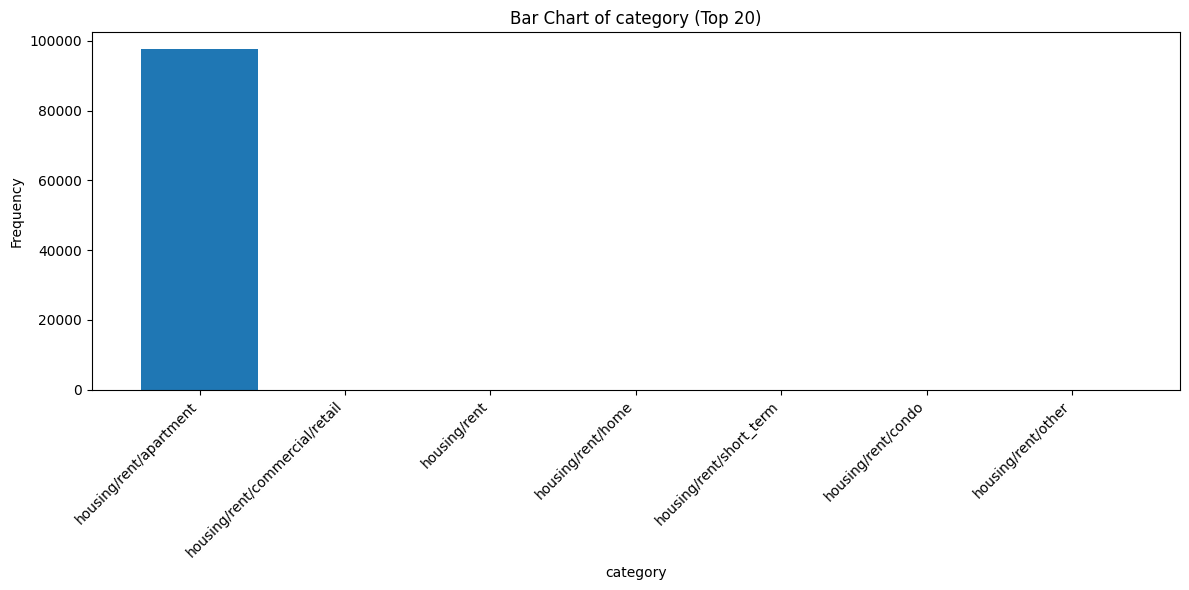


Descriptive Statistics for title:
Number of Unique Values: 57052
Total Count: 97594
Missing Values: 0
Most Frequent Value: Apartment in great location (Frequency: 1053)


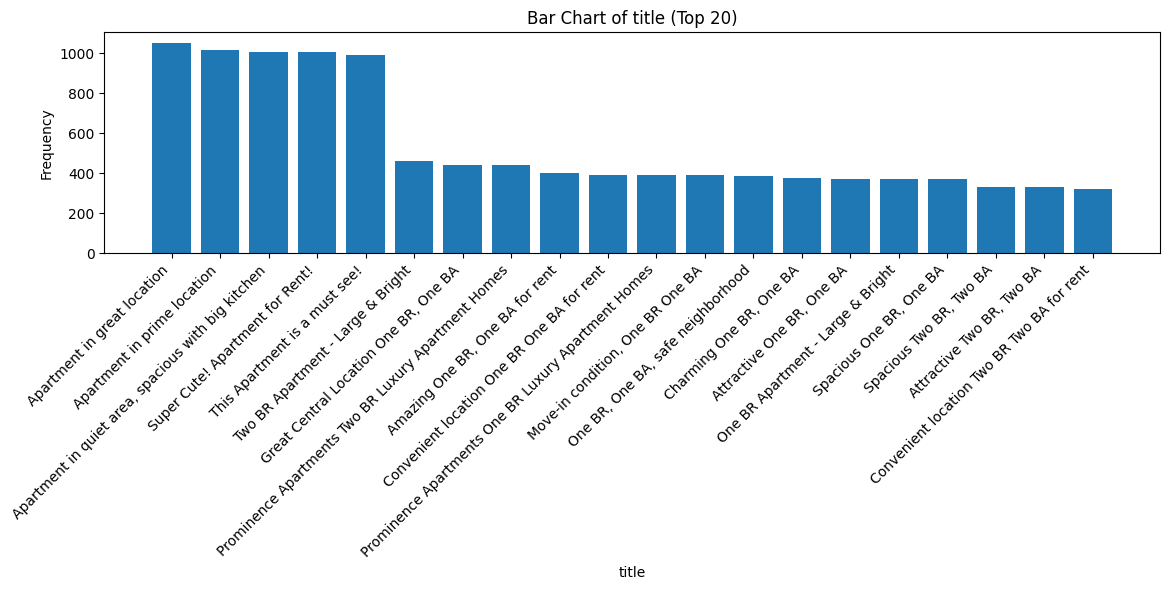


Descriptive Statistics for body:
Number of Unique Values: 92690
Total Count: 97594
Missing Values: 0
Most Frequent Value: When searching for a pet-friendly One-, Two- and 3 Beds apartment homes in Randallstown, look no further than Northwest Crossing. Northwest Crossing's convenient suburban. and Liberty provides you with immediate access to shopping, entertainment, transportation and is directly across from Northwest Hospital. Commuters enjoy easy access to Baltimore's Inner, Baltimore Washington International Airport BWI, Owings Mills, Pikesville, and Catonsville. The Crossing enjoy the comforts of an apartment they are truly proud to with wall-to-wall carpeting, fully-equipped kitchens with dishwashers, over-sized closets and expansive balconies. Outside your home, Northwest Crossing boasts a fitness facilities, basketball and professionally landscaped grounds with picnic areas. Take pleasure in knowing that our professional management team is here to assist you with any need great

/root/.ipykernel/17195/command-2408653827607423-2570347179:36: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


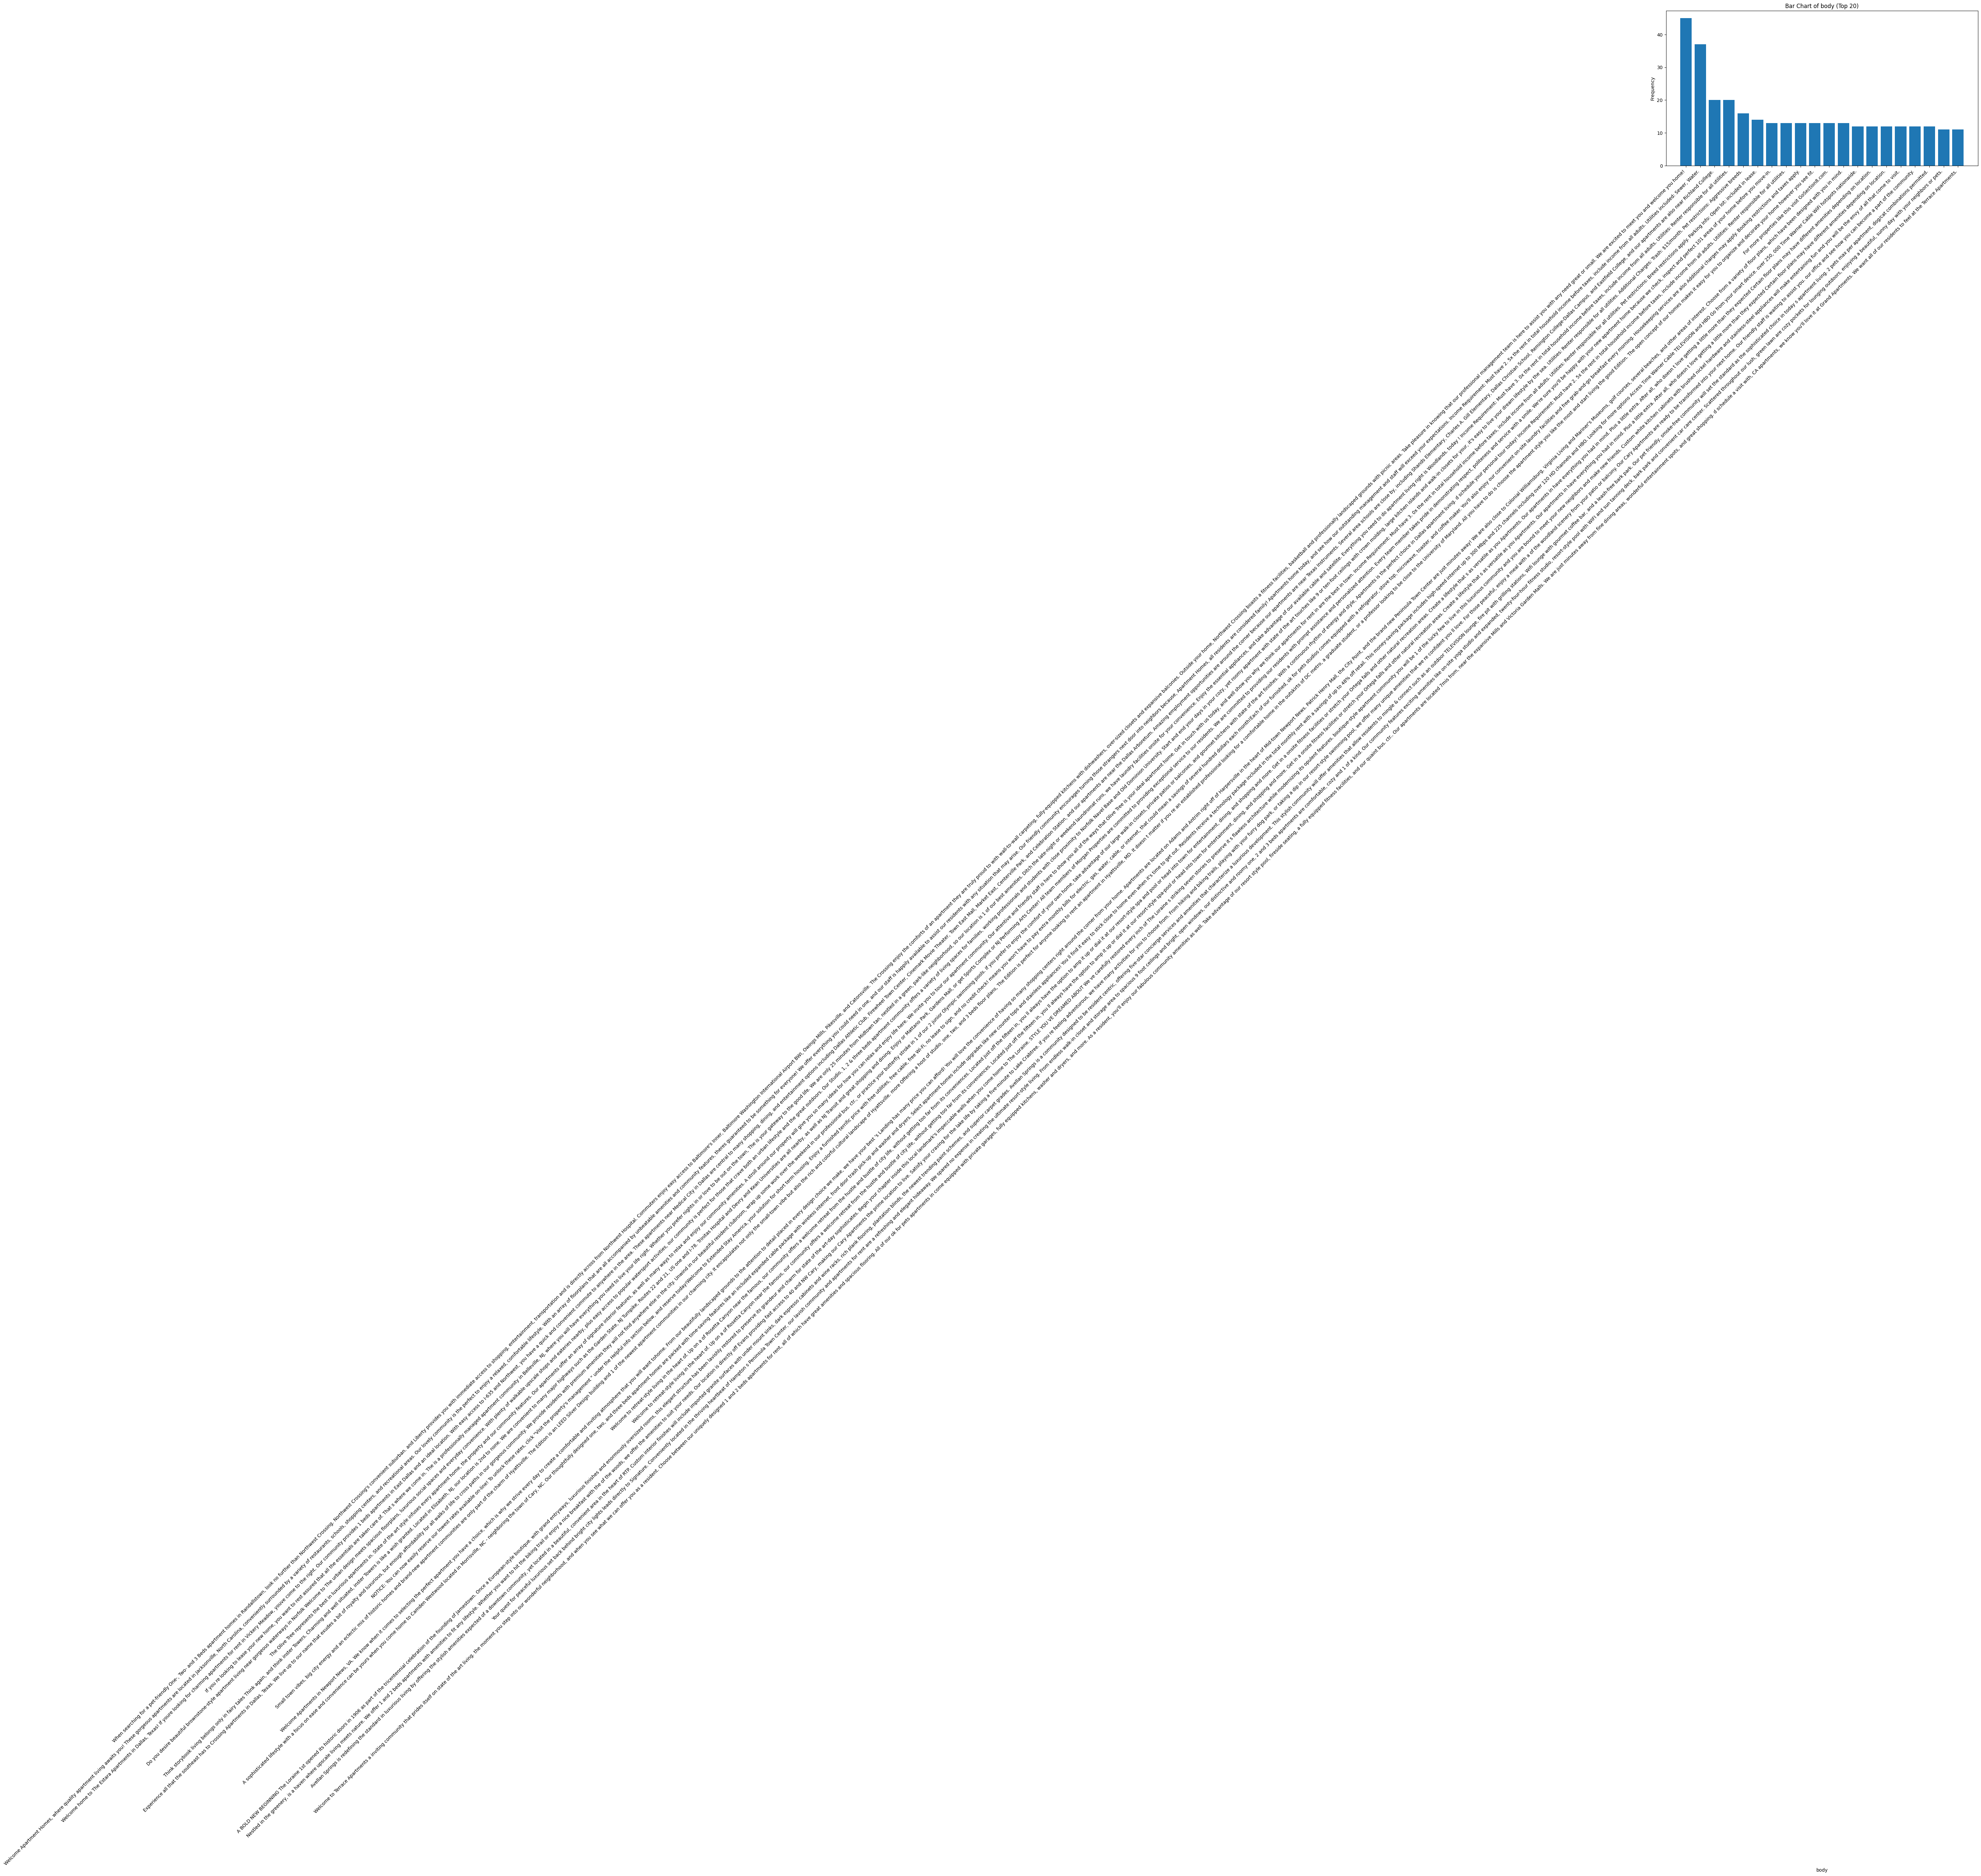


Descriptive Statistics for amenities:
Number of Unique Values: 9579
Total Count: 97594
Missing Values: 0
Most Frequent Value: Unknown (Frequency: 15296)


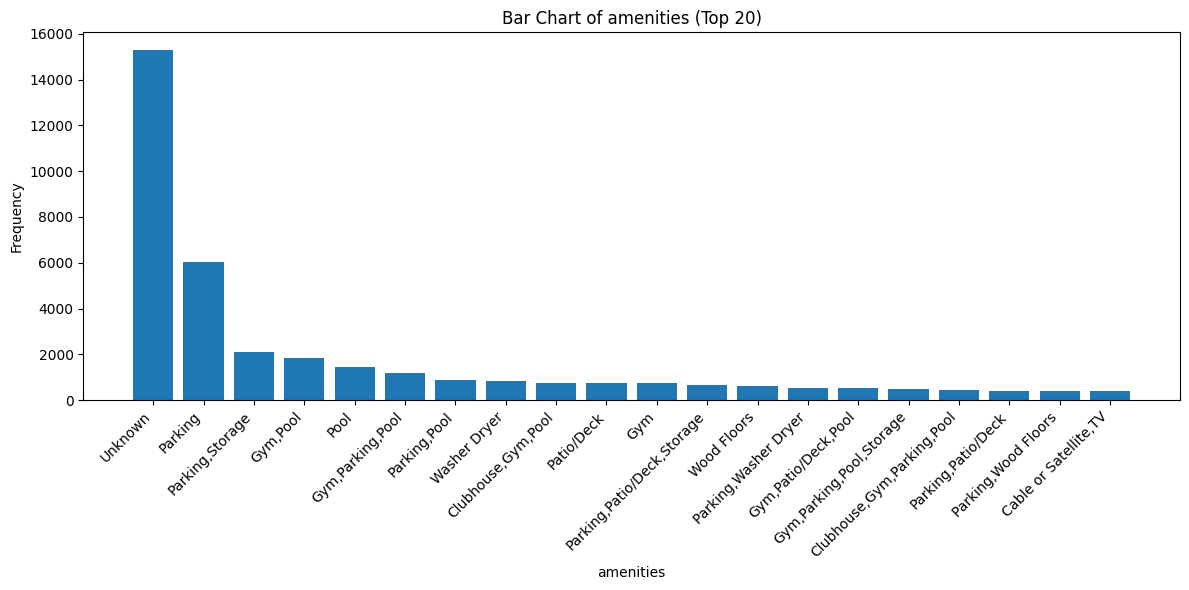


Descriptive Statistics for currency:
Number of Unique Values: 1
Total Count: 97594
Missing Values: 0
Most Frequent Value: USD (Frequency: 97594)


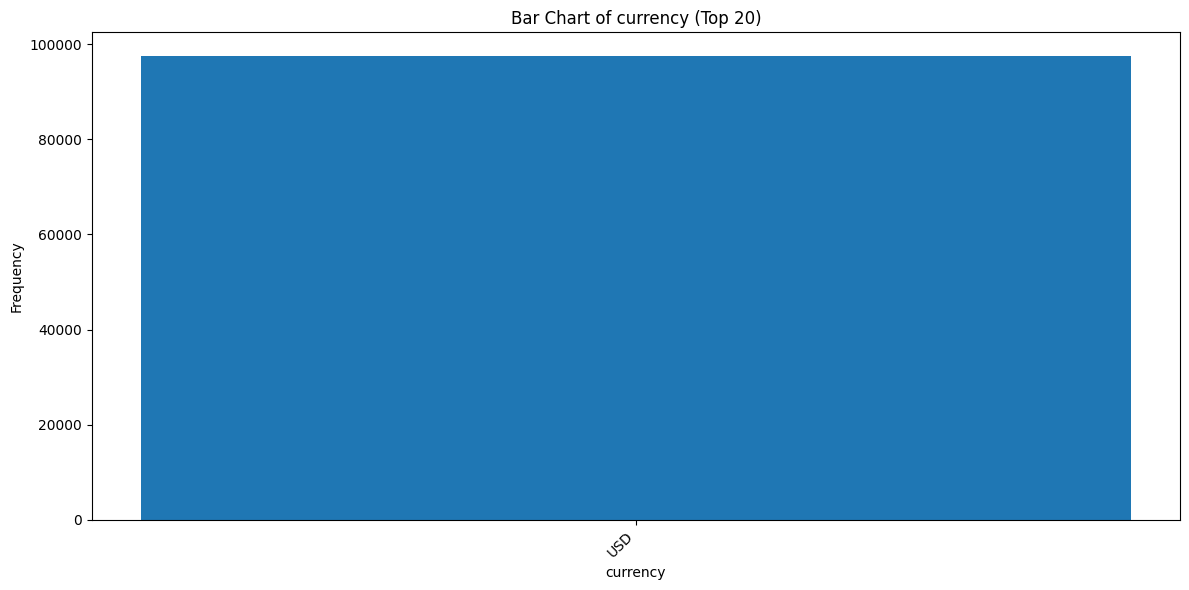


Descriptive Statistics for fee:
Number of Unique Values: 2
Total Count: 97594
Missing Values: 0
Most Frequent Value: No (Frequency: 97404)


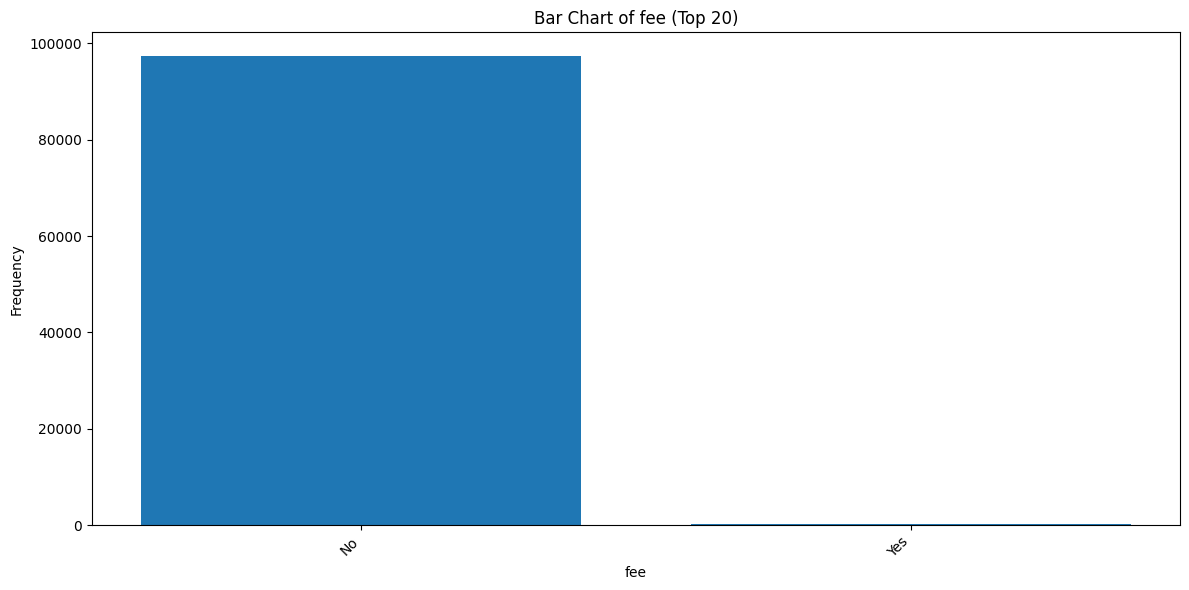


Descriptive Statistics for has_photo:
Number of Unique Values: 3
Total Count: 97594
Missing Values: 0
Most Frequent Value: Yes (Frequency: 54947)


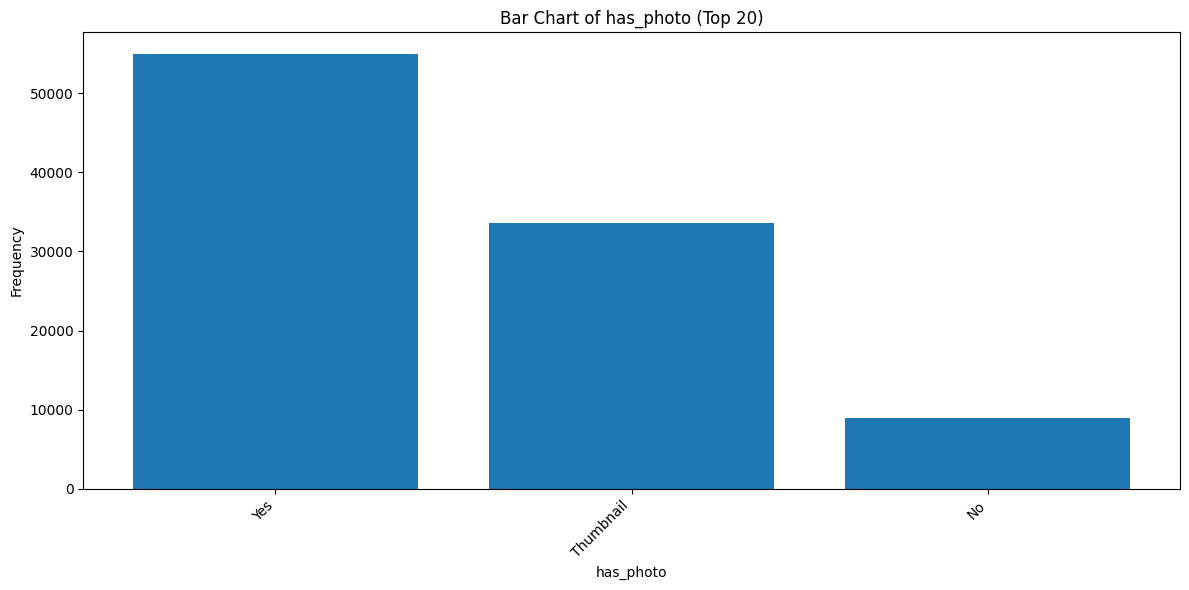


Descriptive Statistics for pets_allowed:
Number of Unique Values: 6
Total Count: 97594
Missing Values: 0
Most Frequent Value: Unknown (Frequency: 54259)


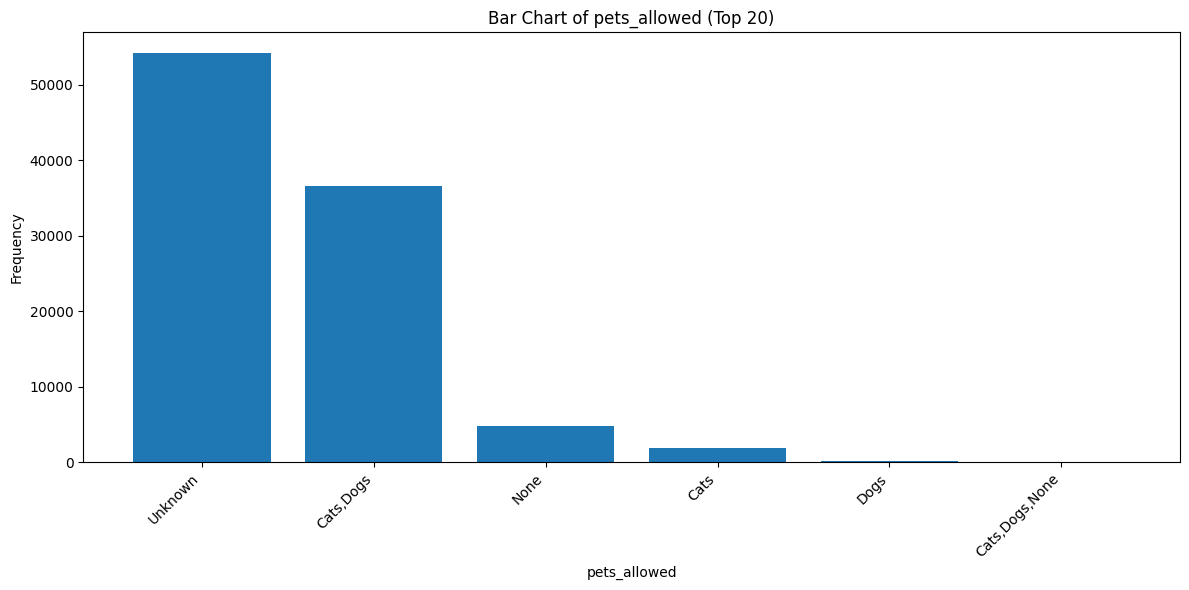


Descriptive Statistics for price_type:
Number of Unique Values: 3
Total Count: 97594
Missing Values: 0
Most Frequent Value: Monthly (Frequency: 97592)


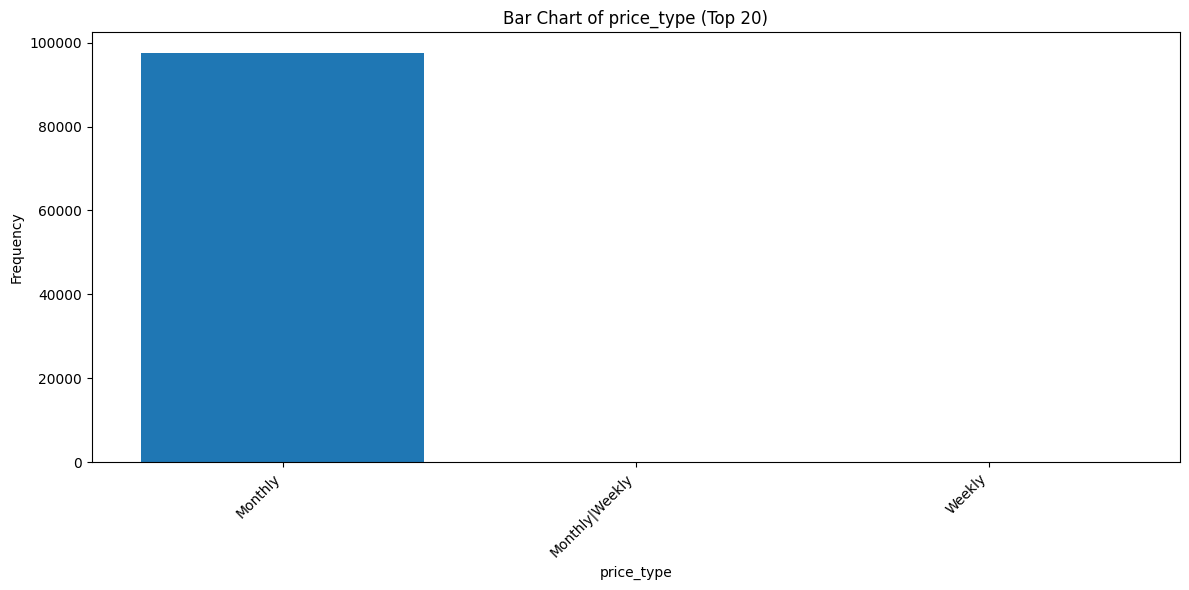


Descriptive Statistics for cityname:
Number of Unique Values: 2916
Total Count: 97594
Missing Values: 0
Most Frequent Value: Dallas (Frequency: 2859)


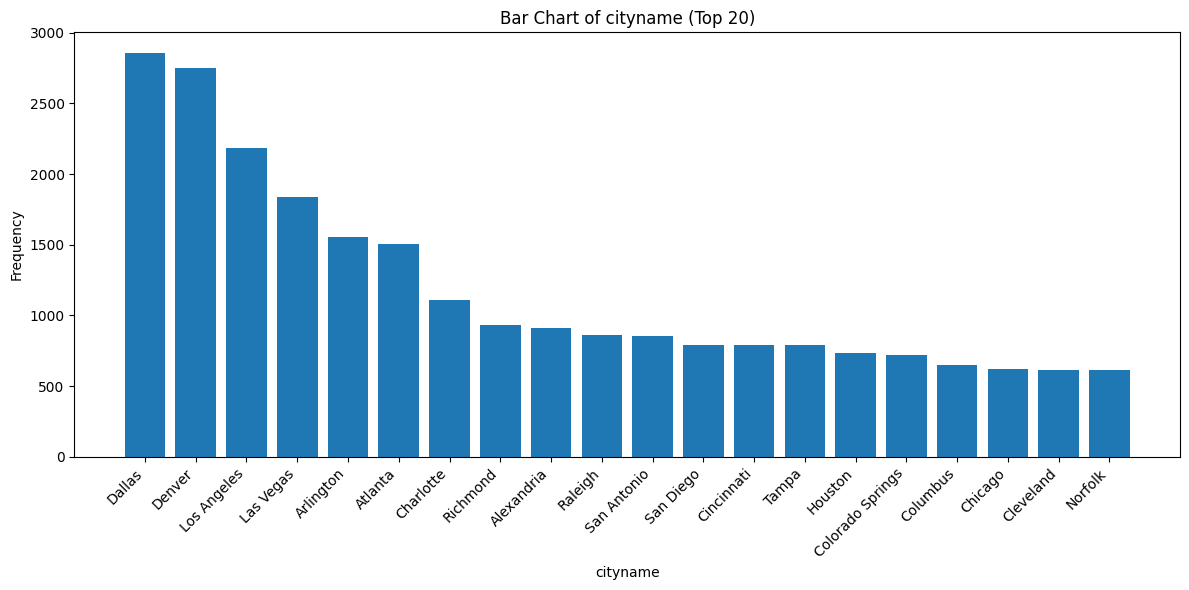


Descriptive Statistics for state:
Number of Unique Values: 51
Total Count: 97594
Missing Values: 0
Most Frequent Value: TX (Frequency: 11167)


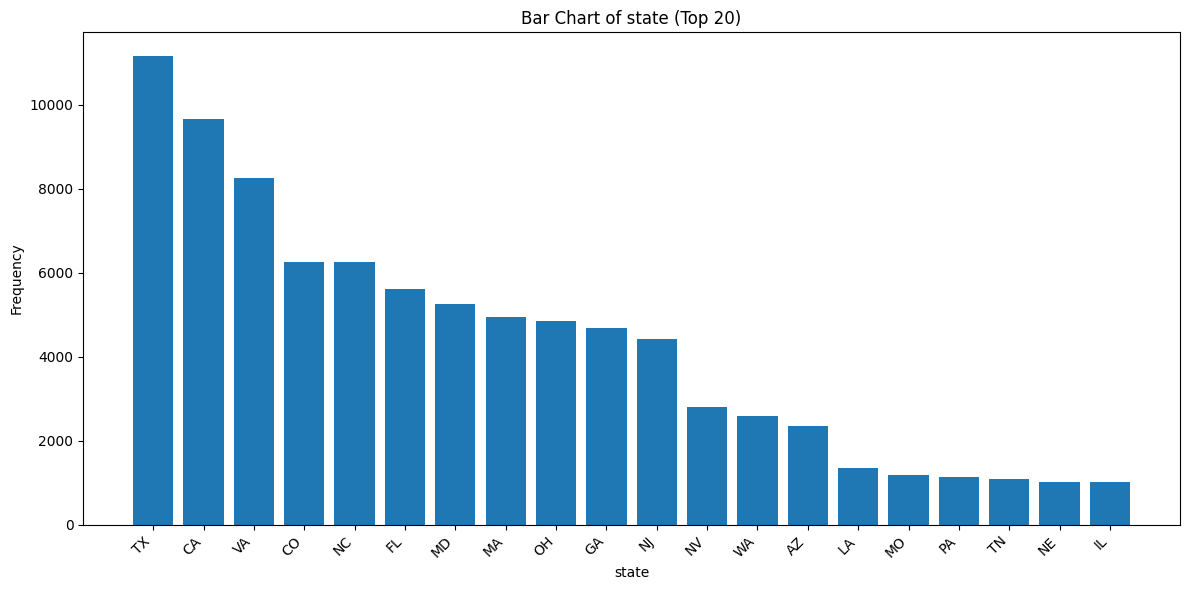


Descriptive Statistics for source:
Number of Unique Values: 25
Total Count: 97594
Missing Values: 0
Most Frequent Value: RentDigs.com (Frequency: 89549)


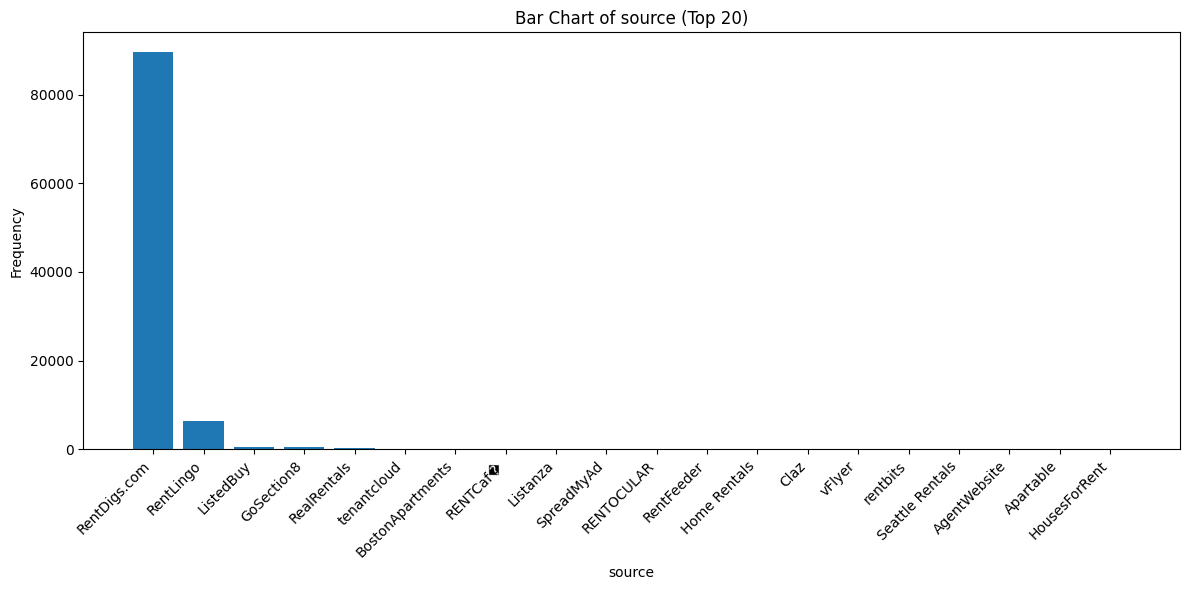


Descriptive Statistics for bathrooms:
Mean: 1.42
Median: 1.00
Standard Deviation: 0.52
Min: 0.00
Max: 4.50
Count: 97594
Missing Values: 0


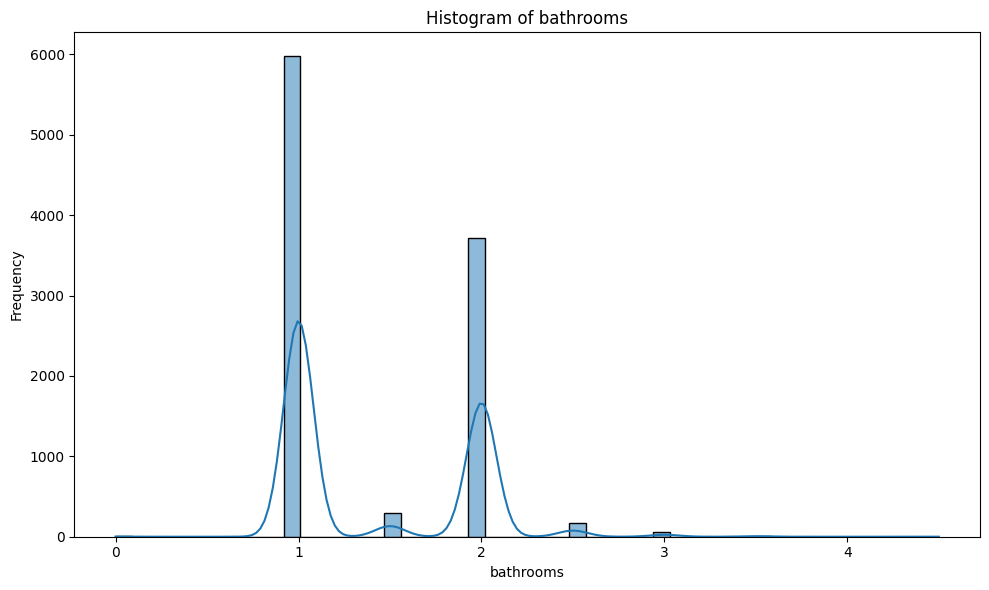


Descriptive Statistics for bedrooms:
Mean: 1.69
Median: 2.00
Standard Deviation: 0.71
Min: 0.00
Max: 6.00
Count: 97594
Missing Values: 0


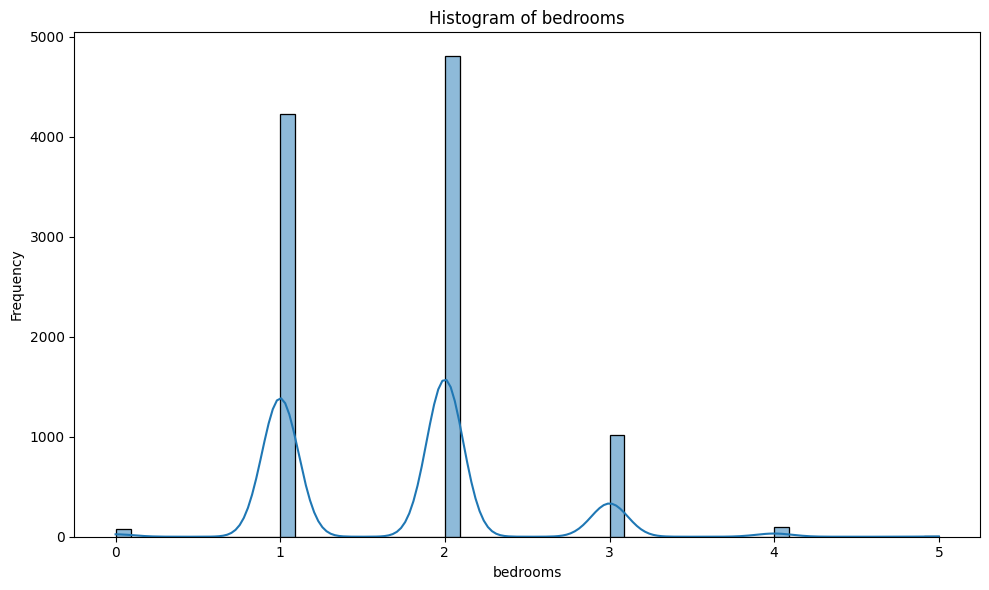


Descriptive Statistics for price:
Mean: 1469.03
Median: 1340.00
Standard Deviation: 640.27
Min: 100.00
Max: 4229.00
Count: 97594
Missing Values: 0


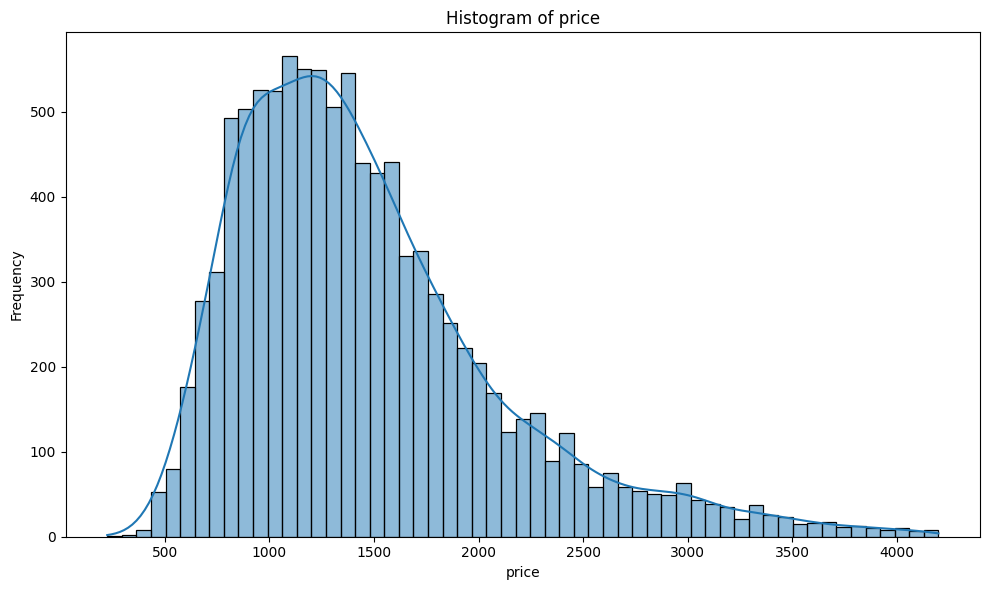


Descriptive Statistics for square_feet:
Mean: 928.53
Median: 900.00
Standard Deviation: 281.32
Min: 101.00
Max: 2118.00
Count: 97594
Missing Values: 0


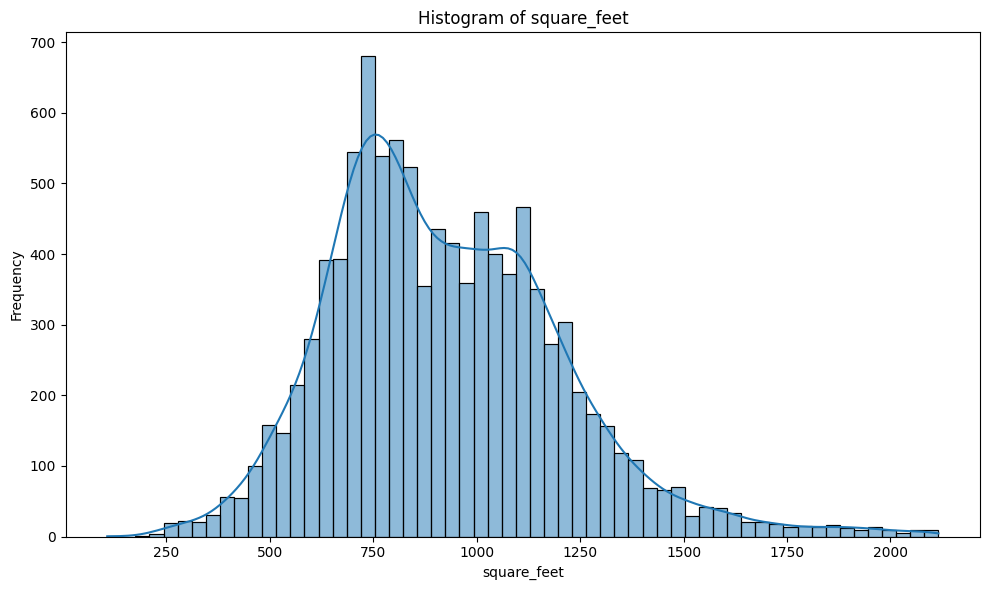


Descriptive Statistics for latitude:
Mean: 36.96
Median: 37.27
Standard Deviation: 4.60
Min: 19.57
Max: 64.83
Count: 97594
Missing Values: 0

Descriptive Statistics for longitude:
Mean: -91.42
Median: -84.53
Standard Deviation: 15.74
Min: -159.37
Max: -68.78
Count: 97594
Missing Values: 0

Descriptive Statistics for Year:
Mean: 2018.84
Median: 2019.00
Standard Deviation: 0.37
Min: 2018.00
Max: 2019.00
Count: 97594
Missing Values: 0

Descriptive Statistics for Month:
Mean: 7.44
Median: 9.00
Standard Deviation: 3.92
Min: 1.00
Max: 12.00
Count: 97594
Missing Values: 0

Descriptive Statistics for week_of_month:
Mean: 3.16
Median: 3.00
Standard Deviation: 0.83
Min: 1.00
Max: 5.00
Count: 97594
Missing Values: 0

Number of outliers removed: 2013
Percentage of data removed: 2.02%


DataFrame[category: string, title: string, body: string, amenities: string, bathrooms: float, bedrooms: int, currency: string, fee: string, has_photo: string, pets_allowed: string, price: double, price_type: string, square_feet: double, cityname: string, state: string, latitude: double, longitude: double, source: string, time: timestamp, Year: bigint, Month: bigint, week_of_month: bigint]

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, LongType, FloatType, DoubleType, StringType
import matplotlib.pyplot as plt

def filter_outliers(df, columns, z_threshold=3):
    for column in columns:
        w = Window.partitionBy(F.lit(1))
        df = df.withColumn(f'{column}_zscore', 
            F.abs((F.col(column) - F.mean(column).over(w)) / F.stddev(column).over(w)))
    
    condition = ' AND '.join([f'{col}_zscore < {z_threshold}' for col in columns])
    return df.filter(condition).drop(*[f'{col}_zscore' for col in columns])

def describe_categorical(df, column):
    stats = df.groupBy(column).agg(F.count('*').alias('count'))
    total_count = df.count()
    unique_count = stats.count()
    null_count = df.filter(F.col(column).isNull()).count()
    most_frequent = stats.orderBy(F.desc('count')).first()
    
    print(f"\nDescriptive Statistics for {column}:")
    print(f"Number of Unique Values: {unique_count}")
    print(f"Total Count: {total_count}")
    print(f"Missing Values: {null_count}")
    print(f"Most Frequent Value: {most_frequent[column]} (Frequency: {most_frequent['count']})")

def plot_categorical(df, column):
    value_counts = df.groupBy(column).count().orderBy(F.desc('count')).limit(20).toPandas()
    plt.figure(figsize=(12, 6))
    plt.bar(value_counts[column].astype(str), value_counts['count'])
    plt.title(f'Bar Chart of {column} (Top 20)')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def describe_numerical(df, column):
    stats = df.select(
        F.mean(column).alias('mean'),
        F.expr(f'percentile({column}, 0.5)').alias('median'),
        F.stddev(column).alias('std'),
        F.min(column).alias('min'),
        F.max(column).alias('max'),
        F.count(column).alias('count'),
        F.sum(F.when(F.col(column).isNull(), 1).otherwise(0)).alias('null_count')
    ).collect()[0]
    
    print(f"\nDescriptive Statistics for {column}:")
    print(f"Mean: {stats['mean']:.2f}")
    print(f"Median: {stats['median']:.2f}")
    print(f"Standard Deviation: {stats['std']:.2f}")
    print(f"Min: {stats['min']:.2f}")
    print(f"Max: {stats['max']:.2f}")
    print(f"Count: {stats['count']}")
    print(f"Missing Values: {stats['null_count']}")
    
def plot_numerical_histogram(df, column):
    sample_size = min(10000, df.count())
    df_sample = df.select(column).sample(False, fraction=sample_size/df.count(), seed=42).toPandas()
    
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_sample, x=column, kde=True)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Assuming 'df' is your PySpark DataFrame
# If it's a PySpark pandas DataFrame, convert it to a PySpark DataFrame:
# df = df.to_spark()

# Filter outliers
outlier_columns = ['square_feet', 'price']
original_count = df.count()
df_filtered = filter_outliers(df, outlier_columns)
df_filtered.cache()  # Cache the filtered DataFrame
filtered_count = df_filtered.count()

# Get column types
numeric_columns = [f.name for f in df_filtered.schema.fields if isinstance(f.dataType, (IntegerType, LongType, FloatType, DoubleType))]
categorical_columns = [f.name for f in df_filtered.schema.fields if isinstance(f.dataType, StringType)]

# Plot and describe categorical variables
for column in categorical_columns:
    describe_categorical(df_filtered, column)
    plot_categorical(df_filtered, column)

columns_to_plot = ['price', 'square_feet', 'bedrooms', 'bathrooms']  # Add or remove columns as needed
# Describe numerical variables, plot histogram if in columns_to_plot
for column in numeric_columns:
    describe_numerical(df_filtered, column)
    if column in columns_to_plot:
        plot_numerical_histogram(df_filtered, column)

# Print information about removed outliers
outliers_removed = original_count - filtered_count
print(f"\nNumber of outliers removed: {outliers_removed}")
print(f"Percentage of data removed: {(outliers_removed / original_count) * 100:.2f}%")

# Unpersist the cached DataFrame
df_filtered.unpersist()

### Descriptive Statistics and Visualizations (After Outliers) for rest of data set
1. **Bar chart of category (Top 20):**
This visual represents a bar chart displaying the frequency of different categories in the dataset.
visual highlights that the dataset is predominantly made up of housing/rent/apartment listings, with very few entries for housing/rent/home and housing/rent/short_term.

2. **Bar chart of title (Top 20):**
This visual represents a bar chart displaying the frequency of the top 20 most common titles in the dataset. The descriptive statistics show titles with ‘Apartment in great location’ are the most common. This bar chart is useful for understanding and identifying patterns or trends in how listings are titled.

3. **Bar chart of body (Top 20):**
This bar chart displays the frequency of the top 20 most common body texts in the dataset. The descriptive statistics show that the most frequent value begins with “When searching for a pet-friendly One-”

4. **Bar chart of amenities (Top 20):**
This visual displays a bar chart with the frequency of the top 20 most common amenities in the dataset. The bar chart highlights the significant issue of missing or unspecified amenities in the dataset indicated by the high frequency of the Unknown value. Parking, Dishwasher, and Refrigerator are the most common with lower frequencies.

5. **Bar chart of currency (Top 20):**
This visual displays a bar chart of  the frequency of USD in currency.

6. **Bar chart of fee (Top 20):**
This visual displays a bar chart of the frequency of fees. 

7. **Bar Chart of has_photo (Top 20):** 
- The "has_photo" column in the dataset provides insights into the visual content of apartment listings. 
- Out of 9,730 total entries, there are three distinct categories for this feature. 
- Notably, every listing has some form of photo information, as there are no missing values in this column. 
- The vast majority of listings, specifically 8,641, include a thumbnail photo. This high frequency of thumbnail photos suggests that visual representation is a standard practice in these apartment listings, likely used to attract potential renters. 
- The presence of three unique values also indicates that there might be other photo options besides thumbnails, though they are less common.
8. **Bar Chart of pets_allowed (Top 20):** 
- The "pets_allowed" column shows pet policies for 9,730 apartment listings. 
- There are 5 different types of pet policies, with no missing information. 
- The most common policy, found in 5,102 listings, allows both cats and dogs. 
- This indicates that over half of the apartments are pet-friendly, accepting both cats and dogs. 
- Such information is useful for pet owners seeking rentals and for understanding overall trends in pet policies among these apartment 
9. **Bar Chart of price_type (Top 20):** 
- The "price_type" column shows how often rent is charged for 9,730 apartment listings. 
- There are 3 different types of pricing periods. 
- Every listing has a price type specified, with no missing information. The overwhelming majority, 9,728 out of 9,730 listings, use monthly pricing. 
- This indicates that almost all apartments in this dataset charge rent on a monthly basis, which is the standard practice for most rental properties. 
- The data suggests very little variation in pricing frequency, with monthly payments being the norm for these listings.
10. **Bar Chart of cityname (Top 20):**
- The "cityname" column shows the cities where the 9,730 apartment listings are located. 
- There are 1,550 different cities represented in the dataset. 
- Every listing has a city name, with no missing information. 
- The most frequently appearing city is Austin, with 523 listings. This indicates a wide variety of locations in the dataset, spanning many cities. 
- However, Austin stands out as the city with the most listings, suggesting it might be a focal point or particularly active rental market in this dataset. 
- The large number of unique cities (1,550) relative to the total listings (9,730) indicates that the dataset covers a broad geographical area with many different urban locations.
11. **Bar Chart of state (Top 20):** 
- The "state" column shows which states the 9,730 apartment listings are located in. 
- There are 51 different states or territories represented. 
- Every listing has a state specified, with no missing information. 
- The most common state is TX (Texas), with 1,731 listings. 
- This indicates that the dataset covers apartments across many U.S. states, but Texas has the highest number of listings.
- The presence of 51 unique values likely includes all 50 U.S. states plus one additional territory or the District of Columbia. 
- Texas's high frequency suggests it's a significant market in this dataset, accounting for about 18% of all listings.
12. **Bar Chart of source (Top 20):**
- The "source" column shows where the 9,730 apartment listings come from. 
- There are 12 different sources of listings in the dataset. 
- Every listing has a source specified, with no missing information. 
- The most common source is RentLingo, which provided 6,668 listings. 
- This indicates that while there are multiple sources for the apartment data, RentLingo is by far the dominant contributor, accounting for about 69% of all listings. 
- The data suggests that RentLingo is a major platform or data provider for this particular dataset of apartment rentals.
13. **Histogram of bathrooms:**
- The "bathrooms" column provides information about the number of bathrooms in the 9,730 apartment listings. 
- The average number of bathrooms is 1.34, with a median of 1.00, indicating that most apartments have around 1 bathroom.
- The standard deviation is 0.55, showing some variation in the number of bathrooms. 
- The minimum number of bathrooms is 0, and the maximum is 5. 
- There are no missing values in this column, meaning every listing specifies the number of bathrooms. 
- This data helps understand the typical bathroom count in the apartment listings, with most apartments having 1 to 2 bathrooms.
14. **Histogram of bedrooms:**
- The "bedrooms" column provides information about the number of bedrooms in the 9,730 apartment listings. 
- The average number of bedrooms is 1.70, with a median of 2.00, indicating that most apartments have around 2 bedrooms. 
- The standard deviation is 0.89, showing some variation in the number of bedrooms. 
- The minimum number of bedrooms is 0, and the maximum is 6. 
- There are no missing values in this column, meaning every listing specifies the number of bedrooms. 
- This data helps understand the typical bedroom count in the apartment listings, with most apartments having 1 to 2 bedrooms.

### Scatter Plot Analysis
- We are creating scatter plots to show the relationship between our numeric values.

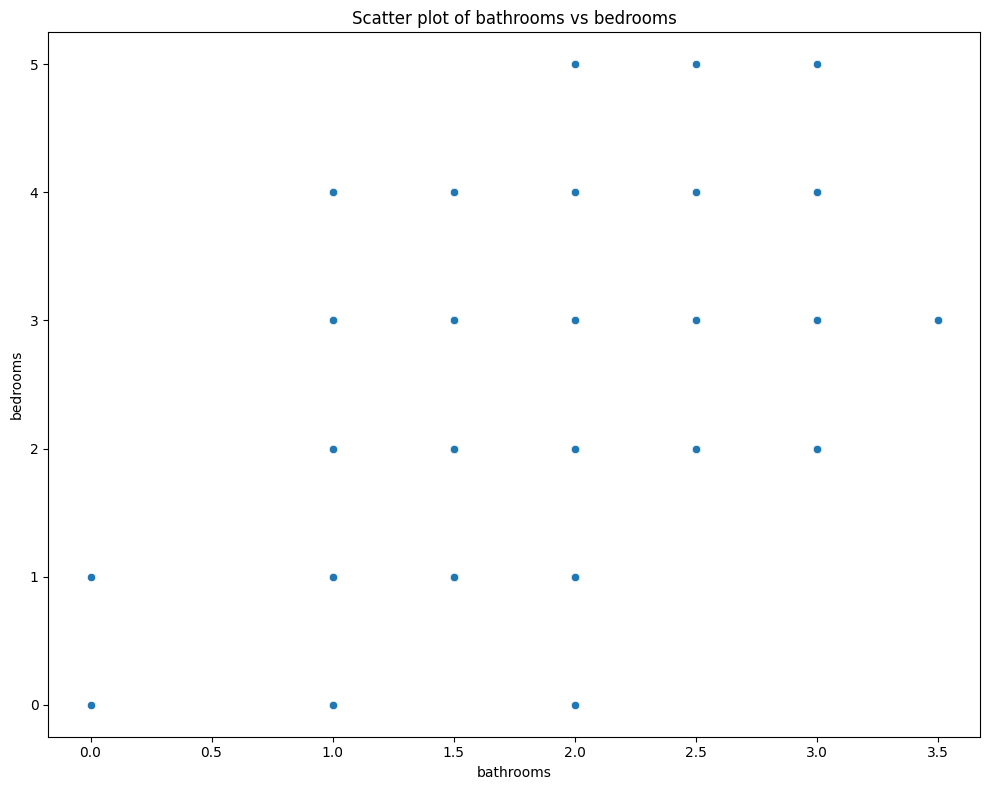

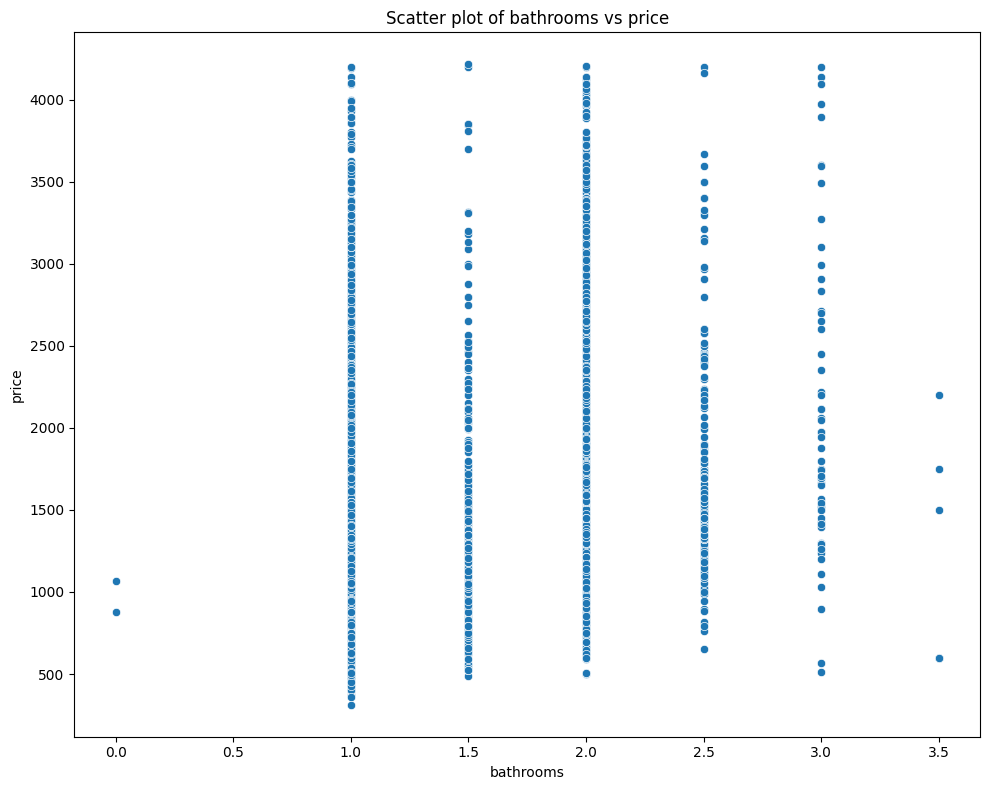

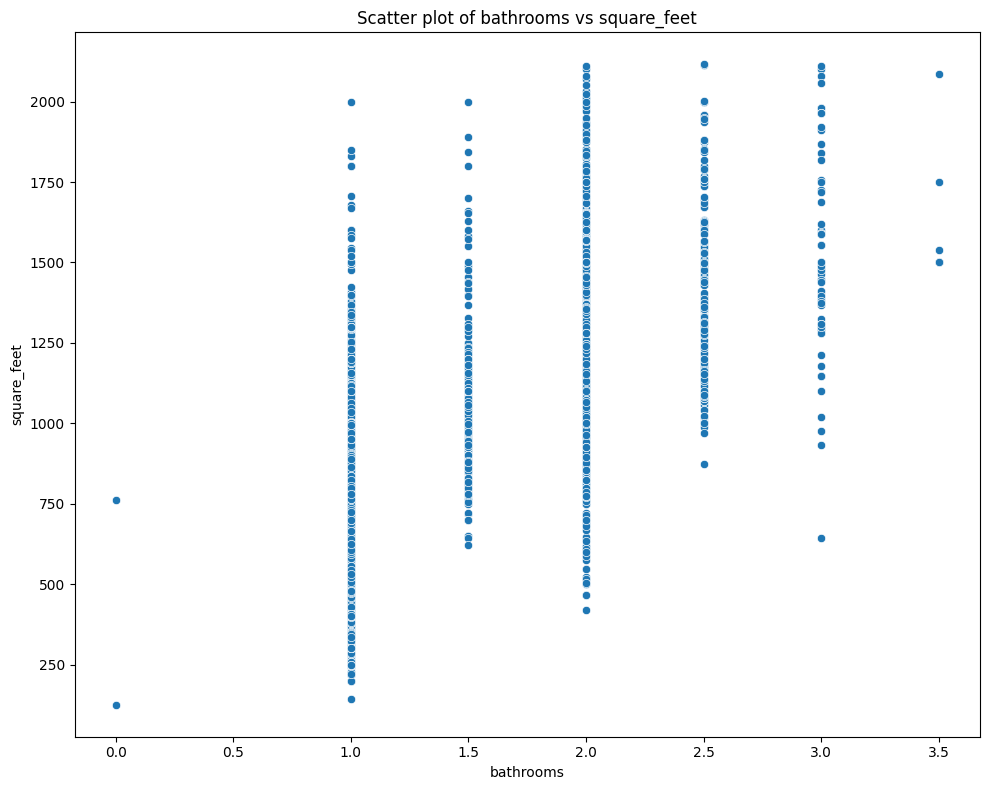

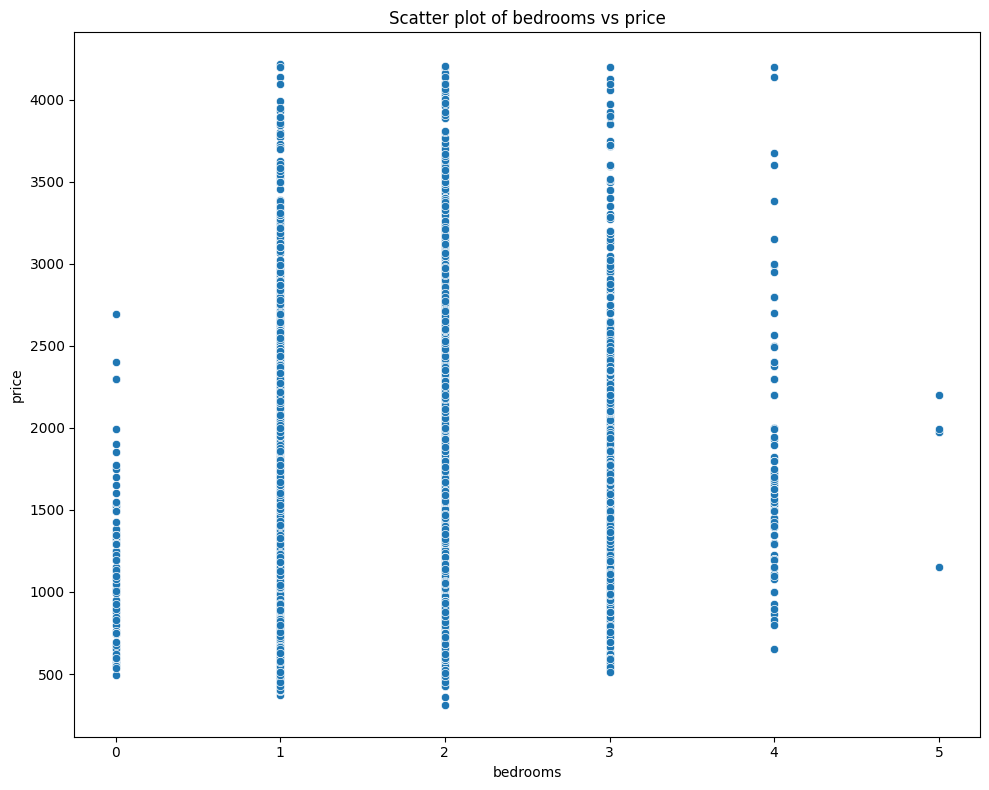

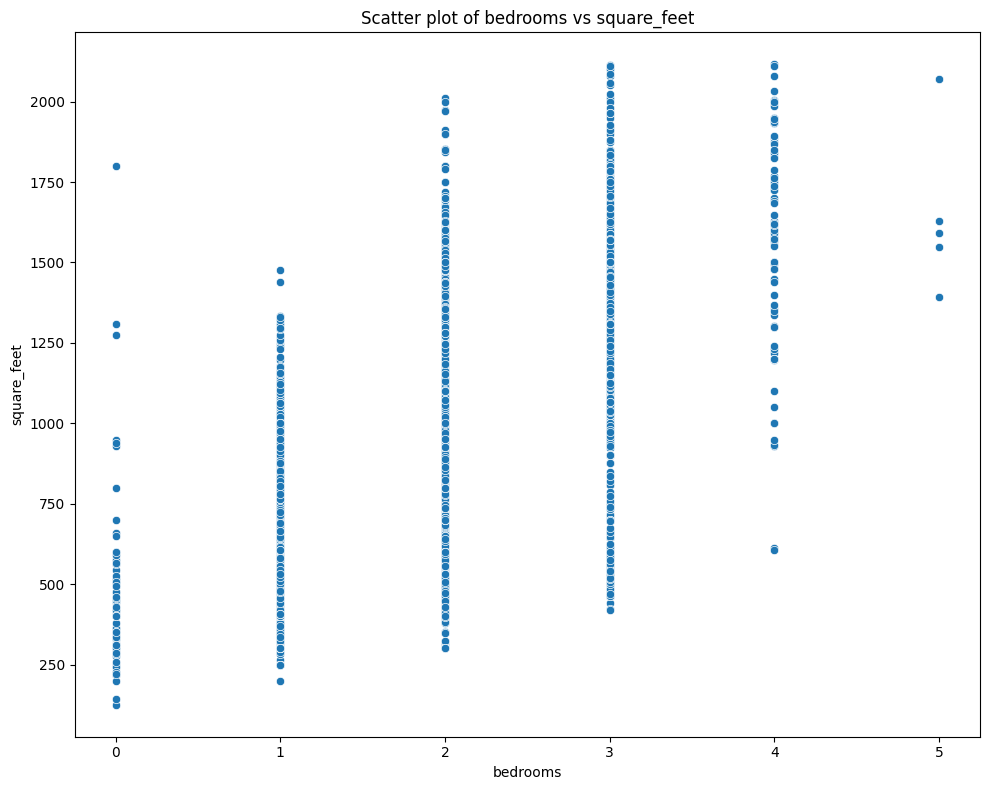

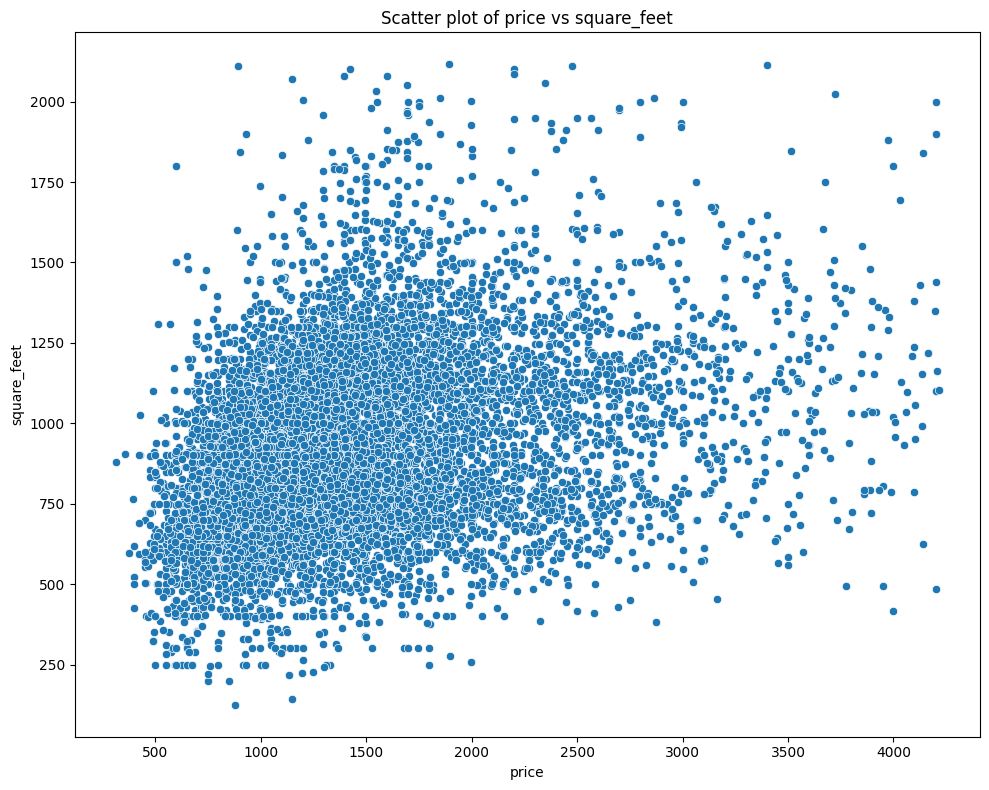

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import combinations

def create_scatter_plots(df, numeric_columns):
    # Exclude specified columns
    columns_to_exclude = ['longitude', 'latitude', 'Year', 'Month', 'week_of_month']
    plot_columns = [col for col in numeric_columns if col not in columns_to_exclude]
    
    # Sample the data if it's too large
    sample_size = min(10000, df.count())  # Adjust this value based on your needs
    df_sample = df.select(plot_columns).sample(False, fraction=sample_size/df.count(), seed=42).toPandas()
    
    # Create scatter plots for each unique pair of numeric columns
    plotted_pairs = set()
    for col1, col2 in combinations(plot_columns, 2):
        if (col1, col2) not in plotted_pairs and (col2, col1) not in plotted_pairs:
            plt.figure(figsize=(10, 8))
            sns.scatterplot(data=df_sample, x=col1, y=col2)
            plt.title(f'Scatter plot of {col1} vs {col2}')
            plt.xlabel(col1)
            plt.ylabel(col2)
            plt.tight_layout()
            plt.show()
            plotted_pairs.add((col1, col2))
# Create scatter plots for numeric columns
create_scatter_plots(df_filtered, numeric_columns)

### Scatter Plot Anaylsis results: 
1. **Scatter Plot of bathrooms vs bedrooms:**
- This scatter plot visualizes the relationship between the number of bathrooms and the number of bedrooms in the dataset. 
- It shows that listings with 1-2 bedrooms and 1-2 bathrooms are common. Higher counts of bedrooms and bathrooms are less frequent.
2. **Scatter Plot of bathrooms vs price:** 
- This scatter plot visualizes the relationship between bathrooms and price. 
- Prices are more variable, with listings spread across a range of prices for each number of bathrooms. 
- Listings with 1 and 2 bathrooms are the most common and show a wide range of prices. 
- This suggests that the number of bathrooms alone does not determine the price. 
- Listings with more than 3 bathrooms are fewer but tend to have higher prices. 
- Listings with 1 or 2 bathrooms prices range from around 200 to over 4000. 
- Listings with 3 or more bathrooms start around 1000 and above with some listings exceeding 4000.
3. **Scatter Plot of bathrooms vs square_feet:** 
- The scatter plot shows the relationship between the number of bathrooms and the square footage of apartments. 
- Each dot represents an apartment listing. 
- The x-axis shows the number of bathrooms, ranging from 0 to 5, and the y-axis shows the square footage, up to around 3,000 square feet. 
- The plot reveals that apartments with more bathrooms generally have larger square footage. 
- There are clear clusters of data points for each bathroom count, indicating common apartment sizes. The trend suggests that as the number of bathrooms increases, the apartment size also tends to increase.- 
4. **Scatter Plot of bedrooms vs price:** 
- This scatter plot shows the relationship between the number of bedrooms and the price of apartments. 
- Each dot represents an apartment listing. 
- The x-axis shows the number of bedrooms, ranging from 0 to 6, and the y-axis shows the price, up to around $4,500. The plot reveals that apartments with more bedrooms generally have higher prices. 
- There are clear clusters of data points for each bedroom count, indicating common price ranges. 
- The trend suggests that as the number of bedrooms increases, the price of the apartment also tends to increase.
5. **Scatter Plot of bedrooms vs square_feet:** 
- Overall Trend: The square footage generally increases with the number of bedrooms.
- Studios and 1-Bedroom Apartments: Range from 100 to 1,500 square feet.
- 2-Bedroom Apartments: Range from 250 to 2,000 square feet, with a higher and broader range than 1-bedroom apartments.
- 3-Bedroom Apartments: Range from 400 to 2,500 square feet.
- 4-Bedroom Apartments: Range from 1,000 to 2,500 square feet.
- 5-Bedroom Apartments: Range from 1,400 to 2,700 square feet.
- 6-Bedroom Apartments: Range from 1,500 to 2,500 square feet.
6. **Scatter Plot of square_feet vs price:**
- Overall Trend: There is a strong positive relationship between price and square footage.
- Main Data Concentration:
- Square Footage: Between 250 and 1,500 square feet.
- Price: Between $500 and $2,500.
- Category Color (price_type):
- Most apartments are rented "Monthly".
- "Weekly" and "Monthly|Weekly" categories have only one data point each, showing no significant relationship.

In [0]:
from pyspark.sql.functions import explode, split, collect_set, size

# Create a DataFrame with unique amenities and their count
unique_amenities_df = df.select(explode(split("amenities", ",")).alias("amenity")) \
    .select("amenity") \
    .distinct() \
    .agg(collect_set("amenity").alias("unique_amenities")) \
    .withColumn("amenity_count", size("unique_amenities"))

# Show the result
unique_amenities_df.display()



unique_amenities amenity_count List(Pool, Alarm, Storage, Playground, Hot Tub, Parking, Clubhouse, Luxury, Gated, AC, View, Elevator, Wood Floors, Patio/Deck, TV, Basketball, Golf, Unknown, Internet Access, Cable or Satellite, Gym, Tennis, Refrigerator, Doorman, Fireplace, Dishwasher, Washer Dryer, Garbage Disposal) 28

In [0]:
# If you need the count as a Python variable
amenity_count = unique_amenities_df.select("amenity_count").collect()[0]["amenity_count"]
print(f"Number of unique amenities: {amenity_count}")

Number of unique amenities: 28


In [0]:
from pyspark.sql.functions import explode, split, count, col

# Create a DataFrame with amenity frequencies
amenity_frequency_df = df.select(explode(split("amenities", ",")).alias("amenity")) \
    .groupBy("amenity") \
    .agg(count("*").alias("frequency")) \
    .orderBy(col("frequency").desc())

# Show the result
amenity_frequency_df.show(n=20, truncate=False)  # Adjust n as needed

# If you need the total number of unique amenities
total_unique_amenities = amenity_frequency_df.count()
print(f"Total number of unique amenities: {total_unique_amenities}")

+------------------+---------+
|amenity           |frequency|
+------------------+---------+
|Parking           |43906    |
|Pool              |43620    |
|Gym               |37413    |
|Patio/Deck        |26584    |
|Washer Dryer      |26097    |
|Storage           |21697    |
|Clubhouse         |19149    |
|Dishwasher        |16628    |
|Unknown           |15945    |
|AC                |15845    |
|Fireplace         |14968    |
|Refrigerator      |14924    |
|Cable or Satellite|12551    |
|Playground        |11341    |
|Internet Access   |11104    |
|Wood Floors       |8886     |
|Gated             |8679     |
|Tennis            |8529     |
|TV                |4509     |
|Elevator          |4340     |
+------------------+---------+
only showing top 20 rows

Total number of unique amenities: 28


In [0]:
from pyspark.sql.functions import explode, split, col, when, collect_set

# Step 1: Get unique amenities
unique_amenities = df.select(explode(split("amenities", ",")).alias("amenity")) \
    .select("amenity") \
    .distinct() \
    .collect()

amenities = [row['amenity'] for row in unique_amenities]

# Step 2: Create one-hot encoded columns
for amenity in amenities:
    df = df.withColumn(f"has_{amenity.replace(' ', '_').replace('-', '_')}", 
                       when(col("amenities").contains(amenity), 1).otherwise(0))

# Show the result
df.select("amenities", *[f"has_{amenity.replace(' ', '_').replace('-', '_')}" for amenity in amenities]).show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------+----------+-----------+---------+--------+------+-------------+--------------+--------------+----------------+----------------------+-----------+---------+--------+---------------+-------------------+--------+------------+-----------+-------+-----------+-----------+--------------+----------------+--------------+--------------------+----------+------+-------------+
|amenities                                                                                                                         |has_Tennis|has_Parking|has_Alarm|has_Golf|has_TV|has_Clubhouse|has_Playground|has_Basketball|has_Refrigerator|has_Cable_or_Satellite|has_Unknown|has_Gated|has_Pool|has_Wood_Floors|has_Internet_Access|has_View|has_Elevator|has_Hot_Tub|has_Gym|has_Storage|has_Doorman|has_Dishwasher|has_Washer_Dryer|has_Patio/Deck|has_Garbage_Disposal|has_Luxury|has_AC|has_Fireplace|
+-

In [0]:
from pyspark.sql.functions import explode, split, col, when, collect_set

# Function to get unique values from a column
def get_unique_values(df, column_name):
    return [row[0] for row in df.select(explode(split(column_name, ",")).alias("value"))
            .select("value")
            .distinct()
            .collect()]

# Get unique values for has_photo
photo_attributes = get_unique_values(df, "has_photo")

# Create one-hot encoded columns for has_photo
for attribute in photo_attributes:
    column_name = f"has_photo_{attribute.replace(' ', '_').replace('-', '_').lower()}"
    df = df.withColumn(column_name, 
                       when(col("has_photo").contains(attribute), 1).otherwise(0))

# Show the result
df.select("has_photo", *[f"has_photo_{attr.replace(' ', '_').replace('-', '_').lower()}" for attr in photo_attributes]).show(truncate=False)

+---------+-------------------+------------+-------------+
|has_photo|has_photo_thumbnail|has_photo_no|has_photo_yes|
+---------+-------------------+------------+-------------+
|Yes      |0                  |0           |1            |
|Yes      |0                  |0           |1            |
|Yes      |0                  |0           |1            |
|Thumbnail|1                  |0           |0            |
|Yes      |0                  |0           |1            |
|Thumbnail|1                  |0           |0            |
|Thumbnail|1                  |0           |0            |
|Yes      |0                  |0           |1            |
|Thumbnail|1                  |0           |0            |
|Yes      |0                  |0           |1            |
|Yes      |0                  |0           |1            |
|Yes      |0                  |0           |1            |
|Yes      |0                  |0           |1            |
|Thumbnail|1                  |0           |0           

In [0]:
import pyspark.pandas as ps
from pyspark.sql import functions as F
from pyspark.sql.types import StringType

# Define the function to map the values
def map_pets_allowed(value):
    if value is None:
        return 'pets_allowed_Unknown'
    elif value == 'None':
        return 'pets_allowed_None'
    else:
        return 'pets_allowed_Yes'

# Register the UDF
map_pets_allowed_udf = F.udf(map_pets_allowed, StringType())

# Create a new column with the transformed values
df = df.withColumn('pets_allowed_transformed', map_pets_allowed_udf(F.col('pets_allowed')))

# Create dummy columns from the new transformed column
df = df.select("*", F.when(F.col("pets_allowed_transformed") == "pets_allowed_Unknown", 1).otherwise(0).alias("pets_allowed_Unknown"),
                  F.when(F.col("pets_allowed_transformed") == "pets_allowed_None", 1).otherwise(0).alias("pets_allowed_None"),
                  F.when(F.col("pets_allowed_transformed") == "pets_allowed_Yes", 1).otherwise(0).alias("pets_allowed_Yes"))

# Drop the intermediate transformed column
df = df.drop("pets_allowed_transformed")

In [0]:
df.head()

Row(category='housing/rent/apartment', title='$1,000 / One BR - Great Deal. MUST SEE. Pet OK!', body='Square footage: 773 square feet, unit number: 01334. Brand New Up-to-date Apartments ! Income Requirement: Must have 3. 0x the rent in total household income before taxes, include income from all adults. Utilities: Renter responsible for all utilities. Pet restrictions: Breed restrictions and 100 pound. limit both pets combined. More units available: two Bd / 1 Bedrooms 937 square feet for $1,110/mo | two Bd / 2 Bedrooms 1,096 square ft for $1,155/mo | one Bd / 1 Bedrooms 773 square feet for $945/mo | two Bd / 2 Bedrooms 1,096 square ft for $1,165/mo | one Bd / 1 Bedrooms 773 sq. feet for $955/mo | one Bd / 1 Bedrooms 773 square ft for $960/mo | one Bd / 1 Bedrooms 773 sq. feet for $935/mo | one Bd / 1 Bedrooms 603 sq. feet for $900/mo | one Bd / 1 Bedrooms 773 sq. feet for $990/mo |', amenities='Unknown', bathrooms=1.0, bedrooms=1, currency='USD', fee='No', has_photo='Yes', pets_allow

In [0]:
df = df.dropna(subset=['price'])


In [0]:
# Count total number of rows
total_rows = df.count()

# Create a list of column names
columns = df.columns

# Initialize an empty dictionary to store results
null_counts = {}

# Loop through each column and count null values
for column in columns:
    null_count = df.filter(F.col(column).isNull()).count()
    null_percentage = (null_count / total_rows) * 100
    null_counts[column] = (null_count, null_percentage)

# Print results
print("Null value counts and percentages:")
for column, (count, percentage) in null_counts.items():
    print(f"{column}: {count} null values ({percentage:.2f}%)")

# If you want to get columns with null values above a certain threshold (e.g., 5%)
columns_with_high_nulls = [col for col, (count, perc) in null_counts.items() if perc > 5]
print("\nColumns with more than 5% null values:")
print(columns_with_high_nulls)

Null value counts and percentages:
category: 0 null values (0.00%)
title: 0 null values (0.00%)
body: 0 null values (0.00%)
amenities: 0 null values (0.00%)
bathrooms: 0 null values (0.00%)
bedrooms: 0 null values (0.00%)
currency: 0 null values (0.00%)
fee: 0 null values (0.00%)
has_photo: 0 null values (0.00%)
pets_allowed: 0 null values (0.00%)
price: 0 null values (0.00%)
price_type: 0 null values (0.00%)
square_feet: 0 null values (0.00%)
cityname: 0 null values (0.00%)
state: 0 null values (0.00%)
latitude: 0 null values (0.00%)
longitude: 0 null values (0.00%)
source: 0 null values (0.00%)
time: 0 null values (0.00%)
Year: 0 null values (0.00%)
Month: 0 null values (0.00%)
week_of_month: 0 null values (0.00%)
has_Tennis: 0 null values (0.00%)
has_Parking: 0 null values (0.00%)
has_Alarm: 0 null values (0.00%)
has_Golf: 0 null values (0.00%)
has_TV: 0 null values (0.00%)
has_Clubhouse: 0 null values (0.00%)
has_Playground: 0 null values (0.00%)
has_Basketball: 0 null values (0.00

In [0]:
from pyspark.sql.functions import col

# Rename the column without the comma
# df = df.withColumnRenamed('allows_pets_Cats,Dogs', 'allows_pets_Cats_Dogs')

# List of columns to remove
columns_to_remove = ['has_photo_thumbnail', 'has_Basketball', 'Year', 'Month', 'pets_allowed_Unknown']

# Drop the columns
df = df.drop(*columns_to_remove)

# Show the result
df.show()

+--------------------+--------------------+--------------------+--------------------+---------+--------+--------+---+---------+------------+------+----------+-----------+--------------+-----+--------+---------+------------+-------------------+-------------+----------+-----------+---------+--------+------+-------------+--------------+----------------+----------------------+-----------+---------+--------+---------------+-------------------+--------+------------+-----------+-------+-----------+-----------+--------------+----------------+--------------+--------------------+----------+------+-------------+------------+-------------+-----------------+----------------+
|            category|               title|                body|           amenities|bathrooms|bedrooms|currency|fee|has_photo|pets_allowed| price|price_type|square_feet|      cityname|state|latitude|longitude|      source|               time|week_of_month|has_Tennis|has_Parking|has_Alarm|has_Golf|has_TV|has_Clubhouse|has_Playg

In [0]:
df.columns

['category',
 'title',
 'body',
 'amenities',
 'bathrooms',
 'bedrooms',
 'currency',
 'fee',
 'has_photo',
 'pets_allowed',
 'price',
 'price_type',
 'square_feet',
 'cityname',
 'state',
 'latitude',
 'longitude',
 'source',
 'time',
 'week_of_month',
 'has_Tennis',
 'has_Parking',
 'has_Alarm',
 'has_Golf',
 'has_TV',
 'has_Clubhouse',
 'has_Playground',
 'has_Refrigerator',
 'has_Cable_or_Satellite',
 'has_Unknown',
 'has_Gated',
 'has_Pool',
 'has_Wood_Floors',
 'has_Internet_Access',
 'has_View',
 'has_Elevator',
 'has_Hot_Tub',
 'has_Gym',
 'has_Storage',
 'has_Doorman',
 'has_Dishwasher',
 'has_Washer_Dryer',
 'has_Patio/Deck',
 'has_Garbage_Disposal',
 'has_Luxury',
 'has_AC',
 'has_Fireplace',
 'has_photo_no',
 'has_photo_yes',
 'pets_allowed_None',
 'pets_allowed_Yes']

In [0]:
type(df)

pyspark.sql.dataframe.DataFrame

In [0]:
df.describe()

DataFrame[summary: string, category: string, title: string, body: string, amenities: string, bathrooms: string, bedrooms: string, currency: string, fee: string, has_photo: string, pets_allowed: string, price: string, price_type: string, square_feet: string, cityname: string, state: string, latitude: string, longitude: string, source: string, week_of_month: string, has_Tennis: string, has_Parking: string, has_Alarm: string, has_Golf: string, has_TV: string, has_Clubhouse: string, has_Playground: string, has_Refrigerator: string, has_Cable_or_Satellite: string, has_Unknown: string, has_Gated: string, has_Pool: string, has_Wood_Floors: string, has_Internet_Access: string, has_View: string, has_Elevator: string, has_Hot_Tub: string, has_Gym: string, has_Storage: string, has_Doorman: string, has_Dishwasher: string, has_Washer_Dryer: string, has_Patio/Deck: string, has_Garbage_Disposal: string, has_Luxury: string, has_AC: string, has_Fireplace: string, has_photo_no: string, has_photo_yes: st

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.types import StringType

# List of columns you want to include
columns_to_include = ['bathrooms', 'bedrooms', 'price', 'square_feet', 'latitude', 'longitude']

# Assuming 'df' is your original DataFrame
summary_df = df.select(*columns_to_include).describe()

@F.udf(StringType())
def format_to_2_decimals(value):
    if value is None:
        return None
    try:
        return f"{float(value):.2f}"
    except ValueError:
        return value

# Apply the UDF to all columns except the first one (which is the summary row names)
formatted_summary = summary_df.select(
    F.col("summary"),
    *[format_to_2_decimals(F.col(c)).alias(c) for c in summary_df.columns if c != "summary"]
)

# Show the formatted results
formatted_summary.display()

summary bathrooms bedrooms price square_feet latitude longitude count 99606.00 99606.00 99606.00 99606.00 99606.00 99606.00 mean 1.44 1.73 1525.64 955.99 36.94 -91.54 stddev 0.55 0.75 902.67 387.38 4.60 15.84 min 0.00 0.00 100.00 101.00 19.57 -159.37 max 9.00 9.00 52500.00 40000.00 64.83 -68.78

In [0]:
# Define the path where you want to save the CSV file
output_path = "dbfs:/FileStore/files/FinalClean_100K.csv"

# Write the DataFrame to CSV
df.write \
  .option("header", "true") \
  .option("sep", ";") \
  .mode("overwrite") \
  .csv(output_path)

print(f"DataFrame has been saved as CSV to: {output_path}")

---------------------------------------------------------------------------
PySparkAttributeError                     Traceback (most recent call last)
File <command-2014535980679540>, line 1
----> 1 df.describe().apply("{0:.5f}".format)

File /databricks/spark/python/pyspark/instrumentation_utils.py:47, in _wrap_function.<locals>.wrapper(*args, **kwargs)
     45 start = time.perf_counter()
     46 try:
---> 47     res = func(*args, **kwargs)
     48     logger.log_success(
     49         module_name, class_name, function_name, time.perf_counter() - start, signature
     50     )
     51     return res

File /databricks/spark/python/pyspark/sql/dataframe.py:3732, in DataFrame.__getattr__(self, name)
   3699 """Returns the :class:`Column` denoted by ``name``.
   3700 
   3701 .. versionadded:: 1.3.0
   (...)
   3729 +---+
   3730 """
   3731 if name not in self.columns:
-> 3732     raise PySparkAttributeError(
   3733         error_class="ATTRIBUTE_NOT_SUPPORTED", message_parameters={"